In [561]:
# Suzan Iloglu, May 21,2020
# Import packages
import csv
import gurobipy as gp
from itertools import product
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
pd.options.display.max_columns =200
from IPython.display import Image

# MAPPING THE NEW POLITICS OF CARE: COMMUNITY HEALTH WORKERS
The project presents multiple options for how individual workers in such a Community Health Corps might be distributed within each state. It shows that what you choose to prioritize greatly impacts where care would be sent. We can define communities in greatest need in many ways: we can think about our current crisis and send people to where the COVID19 pandemic rages most fiercely; we can think of long term measures of social and economic inequality embedded in metrics like the Centers for Disease Control and Prevention’s Social Vulnerability Index; we can focus on the places with too many people dying too young and use the County Health Rankings Years-of-Potential-Life-Lost measure; we can think of joblessness and how the pandemic has thrown many into unemployment and target our resources in this way. 

The followings are our options to choose to define vulnerability:


- SOCIAL VULNERABILITY INDEX
- MEDICAID 
- UNEMPLOYMENT
- YEARS OF POTENTIAL LIFE LOST
- TOTAL COVID CASES
- COVID CASES BY POPULATION
- COVID DEATHS BY POPULATION

We will start with Social Vulnerability Index (SVI) from CDC website.

### I. Importing SVI data which includes the variables for calculating county SVI for each state
The CDC uses both a USA-wide and a state by state SVI scores. For our project given that funding is likely going to be managed at a state level, using a state by state SVI scores makes the most sense and will be most sensitive to regional socioeconomic differences. Even though the CDC SVI scores are calculated using percentile rankings, the data sets include raw data estimates for each variables. The following table shows the variablaes used in the method of calculating SVI scores. 




      American Community Survey (ACS), 2014-2018 (5-year) data for the following estimates:
<img src="Data/img/SVI_comp.png" width="500">


Note: Full documentation for 2018 data is available <a href="https://svi.cdc.gov/data-and-tools-download.html">here</a> 
This part of the code shows preliminary mapping of <a href = "https://svi.cdc.gov/">the CDC's Social Vulnerability Index</a>.

Later in the notebook, we will provide the formula to create the SVI value we use in our project. First, we import the data for the US mainland and Puerto Rico.

In [562]:
## import svi data downloaded from CDC website as cited above

## 48 state SVI scores by county
svi_counties_mainland = gpd.read_file("Data/SVI2018_US_COUNTY/SVI2018_US_county.shp")

## Puerto Rico SVI scores by county
svi_counties_puerto_rico = gpd.read_file("Data/PuertoRico_COUNTY/SVI2018_PuertoRico_county.shp")

## Merge 48 states and Puerto Rico SVI 
svi_counties = pd.concat([svi_counties_mainland,svi_counties_puerto_rico ], sort = False)


In [563]:
## Replacing -999 values with 0 for calculations
svi_county = svi_counties.fillna(0)
svi_county  = svi_county.replace(-999, 0)
svi_county['FIPS'] = svi_county['FIPS'].astype(int)

In [564]:
## Create the list for State
State = svi_county.STATE.unique().tolist()

In [565]:
# Create a seperate dictionary for the variables to calculate SVI

# Persons below poverty estimate, 2014-2018 ACS
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

# Civilian (age 16+) unemployed estimate, 2014-2018 ACS
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.E_UNEMP))

# Per capita income estimate, 2014-2018 ACS
E_PCI = dict(zip(svi_county.FIPS, svi_county.E_PCI))

# Persons (age 25+) with no high school diploma estimate, 2014-2018 ACS
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.E_NOHSDP))

# Persons aged 65 and older estimate
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.E_AGE65))

# Persons aged 17 and younger estimate
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.E_AGE17))

# Population with a disability estimate
E_DISABL = dict(zip(svi_county.FIPS, svi_county.E_DISABL))

# Single parent households with children under 18 estimate
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.E_SNGPNT))

# Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.E_MINRTY))

# Persons (age 5+) who speak English "less than well" estimate, 2014-2018 ACS
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.E_LIMENG))

# Housing in structures with 10 or more units estimate, 2014-2018 ACS
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.E_MUNIT))

# Mobile homes estimate MOE, 2014-2018 ACS
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.E_MOBILE))

# At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS
E_CROWD = dict(zip(svi_county.FIPS, svi_county.E_CROWD))

# Households with no vehicle available estimate, 2014-2018 ACS
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.E_NOVEH))

# Persons in institutionalized group quarters estimate, 2014-2018 ACS
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.E_GROUPQ))

# Percentage of persons below poverty estimate
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

# Medicaid 
Medicaid is a means-tested health insurance program for low-income children, pregnant women, adults, seniors, and people with disabilities. Medicaid is jointly funded by federal and state governments and managed by states within federal standards and a wide range of state options. <a href="https://data.medicaid.gov/Enrollment/State-Medicaid-and-CHIP-Applications-Eligibility-D/n5ce-jxme"> Data Source for Medicaid Enrollment </a> 

In [566]:



# Read the medicaid demand data
df_mm = pd.read_csv("Data/2020_06_Preliminary_applications__eligibility_determinations__and_enrollment_data.csv")
df_mm.head(5)


,State Abbreviation,State Name,Report Date,State Expanded Medicaid,Preliminary_Updated,Final_Report,New Applications Submitted to Medicaid and CHIP Agencies,New Applications Submitted to Medicaid and CHIP Agencies – footnotes,Applications for Financial Assistance Submitted to the State Based Marketplace,Applications for Financial Assistance Submitted to the State Based Marketplace – footnotes,Total Applications for Financial Assistance Submitted at State Level,Total Applications for Financial Assistance Submitted at State Level – footnotes,Individuals Determined Eligible for Medicaid at Application,Individuals Determined Eligible for Medicaid at Application - footnotes,Individuals Determined Eligible for CHIP at Application,Individuals Determined Eligible for CHIP at Application - footnotes,Total Medicaid and CHIP Determinations,Total Medicaid and CHIP Determinations - Footnotes,Medicaid and CHIP Child Enrollment,Medicaid and CHIP Child Enrollment - footnotes,Total Medicaid and CHIP Enrollment,Total Medicaid and CHIP Enrollment - footnotes,Latitude,Longitude,New Georeferenced Column,Total Medicaid Enrollment,Total Medicaid Enrollment - footnotes,Total CHIP Enrollment,Total CHIP Enrollment - footnotes
0,NM,New Mexico,6/1/20,Y,P,N,10769.0,NaN,NaN,NaN,10769.0,NaN,11405.0,NaN,1350.0,NaN,12755.0,NaN,337088.0,NaN,772102,NaN,43.4108,-71.5653,"(43.4108, -71.5653)",734272,NaN,37830,NaN
1,WA,Washington,6/1/20,Y,P,N,91670.0,NaN,60349.0,NaN,152019.0,NaN,81361.0,NaN,967.0,NaN,82328.0,NaN,831382.0,Includes Individuals Enrolled At Any Time in M...,1780968,Includes Individuals Enrolled At Any Time in M...,40.1135,-111.8535,"(40.1135, -111.8535)",1711693,Includes Individuals Enrolled At Any Time in M...,69275,NaN
2,MI,Michigan,6/1/20,Y,P,N,32232.0,NaN,NaN,NaN,32232.0,NaN,27639.0,Does Not Include All MAGI Determinations Made ...,833.0,NaN,28472.0,NaN,967030.0,Does Not Include All Full-Benefit Child Medica...,2439425,Does Not Include All Full-Benefit Medicaid enr...,44.6074,-69.3977,"(44.6074, -69.3977)",2380517,Does Not Include All Full-Benefit Medicaid enr...,58908,NaN
3,CA,California,6/1/20,Y,P,N,148524.0,Does Not Include All Medicaid Applications Sub...,NaN,NaN,148524.0,NaN,169741.0,Does Not Include All Medicaid Determinations M...,12978.0,Does Not Include All CHIP Determinations Made ...,182719.0,Does Not Include All Medicaid Determinations M...,4845851.0,NaN,11847711,NaN,33.7712,-111.3877,"(33.7712, -111.3877)",10561031,NaN,1286680,NaN
4,LA,Louisiana,6/1/20,Y,P,N,23261.0,NaN,NaN,NaN,23261.0,NaN,23316.0,NaN,1435.0,NaN,24751.0,NaN,723094.0,NaN,1585024,NaN,37.6690,-84.6514,"(37.669, -84.6514)",1452945,NaN,132079,NaN


In [672]:
df_mm['State Name'] = df_mm['State Name'].str.upper() 

In [673]:
Medicaid_state = dict(zip(df_mm['State Name'], df_mm['Total Medicaid and CHIP Enrollment']))
print (Medicaid_state)

{'NEW MEXICO': 772102, 'WASHINGTON': 1780968, 'MICHIGAN': 2439425, 'CALIFORNIA': 11847711, 'LOUISIANA': 1585024, 'ARKANSAS': 830467, 'GEORGIA': 1928703, 'CONNECTICUT': 874974, 'NORTH DAKOTA': 96757, 'COLORADO': 1337805, 'VERMONT': 161049, 'TENNESSEE': 1489536, 'MAINE': 232455, 'NORTH CAROLINA': 1851558, 'VIRGINIA': 1497770, 'OKLAHOMA': 797220, 'MINNESOTA': 1085778, 'MISSOURI': 923641, 'RHODE ISLAND': 305208, 'IDAHO': 340742, 'DELAWARE': 239009, 'WYOMING': 59302, 'DISTRICT OF COLUMBIA': 248591, 'WISCONSIN': 1112844, 'NEVADA': 685073, 'KANSAS': 401103, 'NEW YORK': 6263164, 'FLORIDA': 3892552, 'MONTANA': 247333, 'NEW HAMPSHIRE': 193436, 'ALASKA': 231145, 'INDIANA': 1602976, 'HAWAII': 351337, 'NEBRASKA': 254159, 'SOUTH CAROLINA': 1048276, 'ILLINOIS': 2987496, 'ALABAMA': 957116, 'SOUTH DAKOTA': 114059, 'ARIZONA': 1839932, 'PENNSYLVANIA': 3069309, 'MARYLAND': 1372695, 'MISSISSIPPI': 632427, 'WEST VIRGINIA': 521290, 'KENTUCKY': 1416013, 'OHIO': 2788134, 'OREGON': 1053931, 'TEXAS': 4457644, 'U

In [674]:
df_mmm = pd.read_csv("Data/ACSST5Y2018.S2704_data_with_overlays_2020-08-01T140649.csv", header=[1])
df_mmm.head(1)
#df_mmm.dtypes

,id,Geographic Area Name,Estimate!!Total!!Civilian noninstitutionalized population,Margin of Error!!Total MOE!!Civilian noninstitutionalized population,Estimate!!Public Coverage!!Civilian noninstitutionalized population,Margin of Error!!Public Coverage MOE!!Civilian noninstitutionalized population,Estimate!!Percent Public Coverage!!Civilian noninstitutionalized population,Margin of Error!!Percent Public Coverage MOE!!Civilian noninstitutionalized population,Estimate!!Total!!Medicare coverage alone or in combination,Margin of Error!!Total MOE!!Medicare coverage alone or in combination,Estimate!!Public Coverage!!Medicare coverage alone or in combination,Margin of Error!!Public Coverage MOE!!Medicare coverage alone or in combination,Estimate!!Percent Public Coverage!!Medicare coverage alone or in combination,Margin of Error!!Percent Public Coverage MOE!!Medicare coverage alone or in combination,Estimate!!Total!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Total MOE!!Medicare coverage alone or in combination!!Under 19,Estimate!!Public Coverage!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Public Coverage MOE!!Medicare coverage alone or in combination!!Under 19,Estimate!!Percent Public Coverage!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Percent Public Coverage MOE!!Medicare coverage alone or in combination!!Under 19,Estimate!!Total!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Total MOE!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Public Coverage!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Public Coverage MOE!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Percent Public Coverage!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Percent Public Coverage MOE!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Total!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Total MOE!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Public Coverage!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Public Coverage MOE!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Percent Public Coverage!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Percent Public Coverage MOE!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Total!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Total MOE!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Public Coverage MOE!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Percent Public Coverage!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Percent Public Coverage MOE!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Total!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Total MOE!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Public Coverage MOE!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Percent Public Coverage!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Percent Public Coverage MOE!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Total!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Margin of Error!!Total MOE!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Marg

In [675]:
df_mmm['FIPS'] = df_mmm.id.astype(str).str[9:]
df_mmm.head(5)
df_mmm.FIPS.astype(int)
df_mmm['FIPS'] = pd.to_numeric(df_mmm['FIPS'])

In [676]:
ACI_total  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination"]))

In [677]:
print (ACI_total)

{1001: 9049, 1003: 30763, 1005: 7244, 1007: 4272, 1009: 9290, 1011: 2935, 1013: 4814, 1015: 25890, 1017: 7400, 1019: 5105, 1021: 9147, 1023: 3273, 1025: 6716, 1027: 3112, 1029: 3180, 1031: 9926, 1033: 9540, 1035: 2765, 1037: 2155, 1039: 6835, 1041: 3219, 1043: 15478, 1045: 10930, 1047: 13544, 1049: 17896, 1051: 12373, 1053: 6235, 1055: 21998, 1057: 4144, 1059: 6715, 1061: 6647, 1063: 3143, 1065: 4730, 1067: 3651, 1069: 22918, 1071: 11352, 1073: 126944, 1075: 3099, 1077: 15561, 1079: 6877, 1081: 23596, 1083: 14596, 1085: 3540, 1087: 5301, 1089: 48769, 1091: 5053, 1093: 6051, 1095: 20669, 1097: 90962, 1099: 5565, 1101: 52763, 1103: 22180, 1105: 3375, 1107: 4807, 1109: 6945, 1111: 4428, 1113: 14480, 1115: 12599, 1117: 20035, 1119: 4098, 1121: 19979, 1123: 9968, 1125: 34877, 1127: 13887, 1129: 4268, 1131: 4086, 1133: 5577, 2013: 444, 2016: 400, 2020: 49663, 2050: 8680, 2060: 141, 2068: 142, 2070: 1983, 2090: 12661, 2100: 606, 2105: 504, 2110: 4631, 2122: 11347, 2130: 2881, 2150: 2412, 2158

In [678]:


df_m = pd.read_csv("Data/Medicaid_Demand.csv")

# Unemployment 
The unemployment rate is calculated by the U.S. Bureau of Labor Statistics as the percentage of the civilian labor force who are without jobs and have actively sought work within the past four weeks. <a href="https://www.bls.gov/lau/laufaq.htm#Q01"> Data Source for Unemployment  </a> 

In [679]:
# Read the Unemployment data
df_unemp = pd.read_csv("Data/Unemployment.csv")

# Fill NA with 0
df_unemp = df_unemp.fillna(0)


# Years of Potential Life Lost (YPLL)

Years of Potential Life Lost (YPLL) measures the rate of premature deaths by region. YPLL is calculated as the sum of the estimated number of years that individuals would have lived if they had not died before the age of 75 per 100,000 people. <a href="https://www.countyhealthrankings.org/sites/default/files/media/document/2020%20County%20Health%20Rankings%20Data%20-%20v2.xlsx"> Data Source for YPLL.  </a> More information about YPLL can be dounf in this <a href="https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/county-health-rankings-model/health-outcomes/length-of-life/premature-death-ypll"> link. </a> 


In [680]:
# Read the YPLL data
df_y = pd.read_csv("Data/YPLL.csv")

# Fill NA with the mean of the data
df_y = df_y.fillna(df_y.mean())


# Population

In [681]:
# Read the Population data
df_pop = pd.read_csv("Data/County_pop_2019.csv")

# Fill NA with 0
df_pop = df_pop.fillna(0)


In [682]:
# Create a dictionary for the county and population
population_county = df_pop.set_index('FIPS')['pop'].to_dict()

# Create a dictionary for the county and YPLL
YPLL = dict(zip(df_y.FIPS, df_y.YPLL))

# Create a dictionary for the county and Unemployment
Unemployment = dict(zip(df_unemp.FIPS, df_unemp.Unemployed))


# Create a dictionary for the county and Community Health Workers (CHW) demand
# Note that we assume a CHW can serve 55 Medicaid patient so the demand for CHW will be

#Medicaid_demand = dict(zip(df_m.FIPS, df_m.Med_Demand))


In [683]:
df_m.head(100)

,FIPS,Med_Child_Est,Med_Adult_Est,Med_Elderly_Est,Med_Demand
0,1001,6992,1788,583,9363
1,1003,22459,6600,2102,31161
2,1005,4997,1530,662,7189
3,1007,2430,1184,363,3977
4,1009,6033,2289,707,9029
5,1011,2354,529,197,3080
6,1013,3078,1152,424,4654
7,1015,17940,6026,1770,25736
8,1017,5295,1536,610,7441
9,1019,3350,1218,411,4979


In [684]:
#for m in Medicaid_demand:
#    print (m, Medicaid_demand[m])

# COVID-19 Cases & COVID-19 Cases per Capita

What are COVID-19 Cases and COVID-19 Cases per Capita?

COVID-19 cases is an absolute metric of the total number of COVID-19 cases in a county over the last fourteen days.  COVID-19 cases per 100,000 is a relative metric calculated by dividing the number of COVID-19 cases by the estimated county population and multiplying by 100,000.  Cases include both confirmed cases, based on viral testing, and probable cases, based on specific criteria for symptoms and epidemiological exposure. We use NY Times Covid data. 


In [685]:
#### Data with the most recent date in NY Times dataset:

today = time.strftime('%Y-%m-%d')
covid_data_update_date = today#'2020-07-21'#today #or enter a specific date such as '2020-07-06'


In [686]:
## 14 day period defined
data_date_dt = pd.to_datetime(covid_data_update_date,infer_datetime_format = True)

N = 14

date_N_days_ago = data_date_dt - timedelta(days = N)

date_N1_days_ago = data_date_dt - timedelta(days = N+1)

In [687]:
import requests
import io

# URL for mainland US data
url = "http://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
s = requests.get(url).content
covid = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [688]:
covid.head(5)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


Note: Since NY data is seperately available, we first read the NY data for all 5 different borough then combine with the rest of US data.

In [689]:
# URL for NY
url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/boro/boroughs-case-hosp-death.csv"

ny = requests.get(url).content
covid_ny = pd.read_csv(io.StringIO(ny.decode('utf-8')))




In [690]:
Kings = covid_ny[['DATE_OF_INTEREST', 'BK_CASE_COUNT']]
Kings.rename(columns = {'BK_CASE_COUNT': 'cases', 'DATE_OF_INTEREST': 'date'} , inplace=True)
Kings['county'] = 'Kings'
Kings['state'] = 'New York'
Kings['fips'] = '36047'
#Kings.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [691]:
Bronx = covid_ny[['DATE_OF_INTEREST', 'BX_CASE_COUNT']]
Bronx.rename(columns = {'BX_CASE_COUNT': 'cases', 'DATE_OF_INTEREST': 'date'} , inplace=True)
Bronx['state'] = 'New York'
Bronx['county'] = 'Bronx'
Bronx['fips'] = '36005'
#Bronx.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A 

In [692]:
Manhattan = covid_ny[['DATE_OF_INTEREST', 'MN_CASE_COUNT']]
Manhattan.rename(columns = {'MN_CASE_COUNT': 'cases', 'DATE_OF_INTEREST': 'date'} , inplace=True)
Manhattan['state'] = 'New York'
Manhattan['county'] = 'Manhattan'
Manhattan['fips'] = '36061'
#Manhattan.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A 

In [693]:
Queens = covid_ny[['DATE_OF_INTEREST', 'QN_CASE_COUNT']]
Queens.rename(columns = {'QN_CASE_COUNT': 'cases', 'DATE_OF_INTEREST': 'date'} , inplace=True)
Queens['state'] = 'New York'
Queens['county'] = 'Queens'
Queens['fips'] = '36081'
#Queens.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A 

In [694]:
Richmond = covid_ny[['DATE_OF_INTEREST', 'SI_CASE_COUNT']]
Richmond.rename(columns = {'SI_CASE_COUNT': 'cases', 'DATE_OF_INTEREST': 'date'} , inplace=True)
Richmond['state'] = 'New York'
Richmond['county'] = 'Richmond'
Richmond['fips'] = '36085'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A 

In [695]:
# We merge the NY data with the rest of the US data
covid = pd.concat([covid, Kings, Bronx, Manhattan, Queens, Richmond], sort = False)


In [696]:
covid['dt'] = pd.to_datetime(covid['date'], infer_datetime_format=True)
covid.head(5)

,date,county,state,fips,cases,deaths,dt
0,2020-01-21,Snohomish,Washington,53061,1,0.0,2020-01-21
1,2020-01-22,Snohomish,Washington,53061,1,0.0,2020-01-22
2,2020-01-23,Snohomish,Washington,53061,1,0.0,2020-01-23
3,2020-01-24,Cook,Illinois,17031,1,0.0,2020-01-24
4,2020-01-24,Snohomish,Washington,53061,1,0.0,2020-01-24


In [697]:
## subset last last 15 days
covid_last15 = covid[(covid['dt']>date_N1_days_ago) & (covid['dt']<= data_date_dt)].copy()
covid_last15['dt_time_delta'] = covid_last15['dt']-data_date_dt

In [698]:
## calculate new daily cases

## sort values by county and date
covid_last15.sort_values(by=['fips','dt'],inplace=True)
## remove data with 'unknown' counties
covid_last15 = covid_last15[covid_last15['fips'].notnull()].copy()

## calculate daily difference in number of cases
covid_last15['new_cases'] = covid_last15.groupby('fips')['cases'].transform(lambda x: x.diff())
## set negative new cases to zero, this can occuer due to the disperacy in the data

covid_last15.loc[covid_last15.new_cases < 1e-6, 'new_cases'] = 0
covid_last15.sort_index(inplace = True)

In [699]:
## select just last 14 days now that we have daily new cases with 15th day as baseline
covid_last14 = covid_last15[(covid_last15['dt'] > date_N_days_ago) & (covid_last15['dt'] <= data_date_dt)].copy()


In [700]:
## group by FIPS to get case load and follow up demand values for each county
covid_last14_stats = covid_last14.groupby(['fips'])['new_cases'].sum().reset_index(name ='total_cases')

covid_last14_stats.head(5)

,fips,total_cases
0,1001,132.0
1,1003,977.0
2,1005,72.0
3,1007,48.0
4,1009,100.0


In [701]:
## group by FIPS to get case load and follow up demand values for each county
covid_death = covid.groupby(['fips'])['deaths'].sum().reset_index(name ='total_deaths')
covid_death.head(5)

,fips,total_deaths
0,1001,2418.0
1,1003,3504.0
2,1005,568.0
3,1007,572.0
4,1009,675.0


In [702]:
## group by FIPS to get case load each month and follow up demand values for each county
covid['month'] = pd.to_datetime(covid['date'])
covid['year'] = pd.to_datetime(covid['date'])


In [703]:
covid_last14_stats_montly = covid.groupby(['fips', covid.month.dt.month, covid.year.dt.year])['deaths'].sum().reset_index() 

covid_last14_stats_montly['cumulative_death'] = covid_last14_stats_montly.groupby(['fips'])['deaths'].cumsum(axis = 0) 
#covid_last14_stats_montly = covid_last14_stats_montly.groupby(['fips', covid_last14_stats_montly.month,  covid_last14_stats_montly.year])['deaths'].cumsum()

covid_last14_stats_montly.head(10)

,fips,month,year,deaths,cumulative_death
0,1001,3,2020,0.0,0.0
1,1001,4,2020,45.0,45.0
2,1001,5,2020,107.0,152.0
3,1001,6,2020,228.0,380.0
4,1001,7,2020,551.0,931.0
5,1001,8,2020,699.0,1630.0
6,1001,9,2020,733.0,2363.0
7,1001,10,2020,55.0,2418.0
8,1003,3,2020,0.0,0.0
9,1003,4,2020,58.0,58.0


In [704]:
# adding population information from CDC svi dataset
covid_last14_stats = covid_last14_stats.reset_index()
covid_last14_stats['fips'] = covid_last14_stats['fips'].astype(int)
svi_county['FIPS'] = svi_county['FIPS'].astype(int)
covid_last14_stats = pd.merge(left = covid_last14_stats, right = svi_county[['E_TOTPOP','FIPS', 'STATE']], how = 'right', right_on = 'FIPS', left_on = 'fips' )
covid_last14_stats.fillna(0 , inplace=True)

In [705]:
# Create a dictionary for the cumulative COVID deaths in each county
County_covid_death = dict(zip(covid_death.fips, covid_death.total_deaths))


In [706]:
now = pd.to_datetime("now")

print (now)
m_now = now.month
print (m_now)

y_now = now.year

2020-10-03 22:08:13.405994
10


In [707]:
one_month_lag_cumulative_death =  covid_last14_stats_montly[(covid_last14_stats_montly['month'] == m_now-1) & (covid_last14_stats_montly['year'] == y_now)]

# Create a dictionary for the last month COVID deaths in each county
one_month_lag_death = dict(zip(one_month_lag_cumulative_death.fips, one_month_lag_cumulative_death.cumulative_death))

one_month_lag_cumulative_death.head(5)


,fips,month,year,deaths,cumulative_death
6,1001,9,2020,733.0,2363.0
14,1003,9,2020,1425.0,3398.0
21,1005,9,2020,210.0,554.0
29,1007,9,2020,281.0,552.0
37,1009,9,2020,397.0,645.0


In [708]:
two_month_lag_cumulative_death =  covid_last14_stats_montly[(covid_last14_stats_montly['month'] == m_now-2) & (covid_last14_stats_montly['year'] == y_now)]

# Create a dictionary for the last month COVID deaths in each county
two_month_lag_death = dict(zip(two_month_lag_cumulative_death.fips, two_month_lag_cumulative_death.cumulative_death))


two_month_lag_cumulative_death.head(5)

,fips,month,year,deaths,cumulative_death
5,1001,8,2020,699.0,1630.0
13,1003,8,2020,981.0,1973.0
20,1005,8,2020,189.0,344.0
28,1007,8,2020,168.0,271.0
36,1009,8,2020,166.0,248.0


In [709]:
three_month_lag_cumulative_death =  covid_last14_stats_montly[(covid_last14_stats_montly['month'] == m_now - 3) & (covid_last14_stats_montly['year'] == y_now)]


# Create a dictionary for the 3 last month COVID deaths in each county
three_month_lag_death = dict(zip(three_month_lag_cumulative_death.fips, three_month_lag_cumulative_death.cumulative_death))

three_month_lag_cumulative_death.head(5)

print (three_month_lag_death)

{1001.0: 931.0, 1003.0: 992.0, 1005.0: 155.0, 1007.0: 103.0, 1009.0: 82.0, 1011.0: 661.0, 1013.0: 1969.0, 1015.0: 424.0, 1017.0: 2827.0, 1019.0: 402.0, 1021.0: 234.0, 1023.0: 793.0, 1025.0: 382.0, 1027.0: 194.0, 1029.0: 104.0, 1031.0: 173.0, 1033.0: 474.0, 1035.0: 312.0, 1037.0: 119.0, 1039.0: 558.0, 1041.0: 230.0, 1043.0: 268.0, 1045.0: 182.0, 1047.0: 713.0, 1049.0: 468.0, 1051.0: 1270.0, 1053.0: 559.0, 1055.0: 1330.0, 1057.0: 107.0, 1059.0: 920.0, 1061.0: 12.0, 1063.0: 547.0, 1065.0: 1253.0, 1067.0: 248.0, 1069.0: 639.0, 1071.0: 328.0, 1073.0: 12128.0, 1075.0: 42.0, 1077.0: 483.0, 1079.0: 0.0, 1081.0: 3620.0, 1083.0: 169.0, 1085.0: 1445.0, 1087.0: 596.0, 1089.0: 871.0, 1091.0: 815.0, 1093.0: 1266.0, 1095.0: 1142.0, 1097.0: 12475.0, 1099.0: 242.0, 1101.0: 6681.0, 1103.0: 337.0, 1105.0: 69.0, 1107.0: 501.0, 1109.0: 252.0, 1111.0: 843.0, 1113.0: 10.0, 1115.0: 222.0, 1117.0: 2194.0, 1119.0: 884.0, 1121.0: 542.0, 1123.0: 6094.0, 1125.0: 2728.0, 1127.0: 1534.0, 1129.0: 603.0, 1131.0: 666.0

In [710]:

# Create a dictionary for the states of the given the county FIPS
county_of_states = dict(zip(svi_county.FIPS, svi_county.STATE))

# Create a dictionary for the name of the given the county FIPS
county_name = dict(zip(svi_county.FIPS, svi_county.COUNTY))

# Create the list for county FIPS, we consider counties as analogy to the center for community health workers
location = svi_county.FIPS.tolist() #[k for k in SVI_county] #[9001, 9003, 9005, 9007, 9009, 9011, 9013, 9015]#[k for k in SVI_county]




In [711]:
# Create a dictionary for the county and covid cases
covid_cases_county_ny_times = dict(zip(covid_last14_stats.fips, covid_last14_stats.total_cases))
COVID_14days = {}

for j in location:
    if j in covid_cases_county_ny_times:
        COVID_14days[j] = covid_cases_county_ny_times[j]   
    else:
        COVID_14days[j] = 0

#print (three_month_lag_death)
#print (two_month_lag_covid_death)
#print (one_month_lag_covid_death)
for j in location:
    if j not in three_month_lag_death:        
        three_month_lag_death[j] = 0
        
    if j not in two_month_lag_death:        
        two_month_lag_death[j] = 0
        
    if j not in one_month_lag_death:        
        one_month_lag_death[j] = 0
        
    if j not in County_covid_death:
        County_covid_death[j] = 0

In [712]:
#Parameters
pro_c_s = [(i,county_of_states[i]) for i in location ]
cartesian_pro_county_state = gp.tuplelist(pro_c_s)


In [713]:
df = covid_last14_stats
df['fips'] = df['fips'].astype(int)

In [714]:
###############################################################################################
######################## END calculating different types of vulnerabilities ###################

Since we allocate CHW proportional to the county values of certain vulnaribilites within state, we need a few function to help us with the calculations. 



In [715]:
# This function return the value for the state for the given dictionary

# More specifically sum upt the values for the counties of each state

def total_state(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(dict_1[j] for (j,s) in cartesian_pro_county_state.select('*', s))  
    return state_dict



In [716]:
# Calculte the population per state by summing up the population in each county in the state
State_pop = total_state(population_county)

In [717]:


# This function returns the ratio of the dict value for county and state of the county
def Proportional(county_level, state_level):
    
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6:
            prop[j] = (county_level[j]/state_level[s])    
        else:
            prop[j] = 0
                
    return prop

In [718]:
print (ACI_total)
print (ACI_total[35039])

{1001: 9049, 1003: 30763, 1005: 7244, 1007: 4272, 1009: 9290, 1011: 2935, 1013: 4814, 1015: 25890, 1017: 7400, 1019: 5105, 1021: 9147, 1023: 3273, 1025: 6716, 1027: 3112, 1029: 3180, 1031: 9926, 1033: 9540, 1035: 2765, 1037: 2155, 1039: 6835, 1041: 3219, 1043: 15478, 1045: 10930, 1047: 13544, 1049: 17896, 1051: 12373, 1053: 6235, 1055: 21998, 1057: 4144, 1059: 6715, 1061: 6647, 1063: 3143, 1065: 4730, 1067: 3651, 1069: 22918, 1071: 11352, 1073: 126944, 1075: 3099, 1077: 15561, 1079: 6877, 1081: 23596, 1083: 14596, 1085: 3540, 1087: 5301, 1089: 48769, 1091: 5053, 1093: 6051, 1095: 20669, 1097: 90962, 1099: 5565, 1101: 52763, 1103: 22180, 1105: 3375, 1107: 4807, 1109: 6945, 1111: 4428, 1113: 14480, 1115: 12599, 1117: 20035, 1119: 4098, 1121: 19979, 1123: 9968, 1125: 34877, 1127: 13887, 1129: 4268, 1131: 4086, 1133: 5577, 2013: 444, 2016: 400, 2020: 49663, 2050: 8680, 2060: 141, 2068: 142, 2070: 1983, 2090: 12661, 2100: 606, 2105: 504, 2110: 4631, 2122: 11347, 2130: 2881, 2150: 2412, 2158

In [719]:
#ACI
ACI_State = total_state(ACI_total)

In [720]:
# Create dicts for the variables of SVI
E_POV = dict(zip(svi_county.FIPS, svi_county.EP_POV))
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.EP_UNEMP))
E_PCI = dict(zip(svi_county.FIPS, svi_county.EP_PCI))
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.EP_NOHSDP))
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.EP_AGE65))
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.EP_AGE17))
E_DISABL = dict(zip(svi_county.FIPS, svi_county.EP_DISABL))
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.EP_SNGPNT))
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.EP_MINRTY))
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.EP_LIMENG))
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.EP_MUNIT))
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.EP_MOBILE))
E_CROWD = dict(zip(svi_county.FIPS, svi_county.EP_CROWD))
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.EP_NOVEH))
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.EP_GROUPQ))


# Calculate the state value for the SVI variables
E_POV_State = total_state(E_POV)
E_UNEMP_State = total_state(E_UNEMP) 
E_PCI_State = total_state(E_PCI)
E_NOHSDP_State = total_state(E_NOHSDP) 
E_AGE65_State = total_state(E_AGE65)
E_AGE17_State = total_state(E_AGE17)
E_DISABL_State = total_state(E_DISABL)
E_SNGPNT_State = total_state(E_SNGPNT)
E_MINRTY_State = total_state(E_MINRTY)
E_LIMENG_State = total_state(E_LIMENG)
E_MUNIT_State = total_state(E_MUNIT)
E_MOBILE_State = total_state(E_MOBILE)
E_CROWD_State = total_state(E_CROWD)
E_NOVEH_State = total_state(E_NOVEH)
E_GROUPQ_State = total_state(E_GROUPQ)



# Calculate the proportinal values for the SVI variables
E_POV_Prop = Proportional(E_POV, E_POV_State )
E_UNEMP_Prop = Proportional(E_UNEMP, E_UNEMP_State ) 
E_PCI_Prop = Proportional(E_PCI, E_PCI_State )
E_NOHSDP_Prop = Proportional(E_NOHSDP, E_NOHSDP_State ) 
E_AGE65_Prop = Proportional(E_AGE65, E_AGE65_State )
E_AGE17_Prop = Proportional(E_AGE17, E_AGE17_State )
E_DISABL_Prop = Proportional(E_DISABL, E_DISABL_State )
E_SNGPNT_Prop = Proportional(E_SNGPNT, E_SNGPNT_State )
E_MINRTY_Prop = Proportional(E_MINRTY, E_MINRTY_State )
E_LIMENG_Prop = Proportional(E_LIMENG, E_LIMENG_State )
E_MUNIT_Prop = Proportional(E_MUNIT, E_MUNIT_State )
E_MOBILE_Prop = Proportional(E_MOBILE, E_MOBILE_State )
E_CROWD_Prop = Proportional(E_CROWD, E_CROWD_State )
E_NOVEH_Prop = Proportional(E_NOVEH, E_NOVEH_State )
E_GROUPQ_Prop = Proportional(E_GROUPQ, E_GROUPQ_State )

ACI_Prop = Proportional(ACI_total, ACI_State)


# SVI calculation 

We calculate the ratio of county value to state value by population for each SVI variables (we use EP-estimate percentage- values in the CDC data set), then we take the average of all 15 SVI variables. 

Let SVI variable set be K, where  

K = { Below Poverty, Unemployed, Income, No High School Diploma, Aged 65 or Older, Aged 17 or Younger, Civilian with a Disability, Single-Parent Households, Minority, Speaks English “Less than Well”, Multi-Unit Structures, Mobile Homes, Crowding, No Vehicle, Group Quarters }

We will use these variables in a county base and state base. While County base values are exactly same as the estimated values for these variables in the CDC website, to calculate the state base, we simply sum the county values for all of the counties in each state for each variable. Then we use the following formula to calculate the SVI value for each county.

Let $S$ is the set of states and $j$ is a county in the state $s$, where $s \in S$, $c^k_j$ SVI variable $k \in K$ value for county j, and $c_s$ SVI variable value for state s.

$SVI_j = \frac{1}{15}\sum_{k \in K} \frac{c^k_j}{c^k_s}$


In [721]:

from collections import Counter
# Sum all SVI variable values for each county
SVI_county_sum = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_MINRTY_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))

# Divide the sum of all SVI variable values
SVI_county = {j: SVI_county_sum[j]/15 for j in SVI_county_sum }


In [722]:
#print ('Med', Medicaid_demand[4017], 'Pop', population_county[4017], 'Med_capita', 100000*(Medicaid_demand[4017]/population_county[4017]))

In [723]:
#Further we create additional vulnerability values by considering SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita and the number of Medicaid enrolles in each county together

Covid_capita = {j: 100000*(COVID_14days[j]/population_county[j]) for j in location}

Covid_death_capita = {j: 100000*(County_covid_death[j]/population_county[j]) for j in location}

Medicaid_capita = {j: 100000*(Medicaid_demand[j]/population_county[j]) for j in location}

Unemployment_capita = dict(zip(df_unemp.FIPS, df_unemp.Rate))

Three_month_lag_covid_death_capita = {j: 100000*(three_month_lag_death[j]/population_county[j]) for j in location}

Two_month_lag_covid_death_capita = {j: 100000*(two_month_lag_death[j]/population_county[j]) for j in location}

One_month_lag_covid_death_capita = {j: 100000*(one_month_lag_death[j]/population_county[j]) for j in location}

# Proportional Allocation

We consider allocating 1 million CHW over the states proportional to Medicaid enrollment in each state. Further, we allocate CHW to counties in each state proportional to different county vulnerability criterias as follow.

- MEDICAID
- SVI
- YPLL
- UNEMPLOYMENT
- LAST 14 DAYS COVID CASES
- LAST 14 DAYS COVID CASES / POP
- COVID DEATHS / POP

To calculate the total number of allocated CHW to per county according to these vulnerability criterias, we define the following function called "Proportional_allocation", in which we multiply the CHW allocated to each state with the ratio of the chosen vulnerability criteria of the county to the chosen vulnerability criteria of the state, the function return a dictionary with the counties as keys and the number of CHW allocated to each county for the chosen vulnerability criteria as values. 

In [724]:
def Proportional_allocation(county_level, state_level, state_budget):
    prop_allocate = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6:
            prop_allocate[j,s] = (county_level[j]/state_level[s])*state_budget[s]
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [725]:
#Medicaid_demand = Proportional_allocation(ACI_total, ACI_State, Medicaid_state)

for s in State:
    print (s)
    print ( ACI_State[s])
    print (Medicaid_state[s])
#for m in Medicaid_demand:
#    print (m, Medicaid_demand[m])

NEW MEXICO
640436
772102
ALABAMA
943319
957116
ALASKA
140351
231145
ARIZONA
1503751
1839932
ARKANSAS
756245
830467
CALIFORNIA
9916261
11847711
COLORADO
1016127
1337805
CONNECTICUT
699577
874974
DELAWARE
184730
239009
FLORIDA
3739612
3892552
GEORGIA
1778595
1928703
IDAHO
284257
340742
ILLINOIS
2483653
2987496
INDIANA
1128919
1602976
IOWA
567337
699741
KANSAS
395595
401103
KENTUCKY
1126718
1416013
LOUISIANA
1145325
1585024
MAINE
251102
232455
MARYLAND
1052883
1372695
MASSACHUSETTS
1551131
1616404
MICHIGAN
2161340
2439425
MINNESOTA
963816
1085778
MISSISSIPPI
708150
632427
MISSOURI
877844
923641
MONTANA
185140
247333
NEBRASKA
243334
254159
NEVADA
528340
685073
NEW HAMPSHIRE
168974
193436
NEW JERSEY
1458112
1759653
NEW YORK
4928317
6263164
NORTH CAROLINA
1825361
1851558
NORTH DAKOTA
82051
96757
OHIO
2341031
2788134
OKLAHOMA
675502
797220
OREGON
925081
1053931
PENNSYLVANIA
2373720
3069309
RHODE ISLAND
229601
305208
SOUTH CAROLINA
944418
1048276
SOUTH DAKOTA
122081
114059
TENNESSEE
1335171
14

KeyError: 'PUERTO RICO'

In [726]:
# Dictionaries for the different vulnerability criteria values for states

# Dictionary for total Medicaid patient numbers for each state
Medicaid_demand_state = total_state(Medicaid_demand) 

# Dictionary for total positive COVID cases for last 14 days in each state
Covid_state = total_state(COVID_14days) 

# Dictionary for total SVI values for each state
SVI_state = total_state(SVI_county) 

# Dictionary for total YPLL values for each state
YPLL_state = total_state(YPLL) 

# Dictionary for total Unemployment numbers for each state
Unemployment_state = total_state(Unemployment)  

In [727]:
# Dictionary for the total Covid per capita for each state
Total_covid_cap = total_state(Covid_capita) 


# Dictionary for the total Covid death per capita for each state
Total_covid_death_cap = total_state(Covid_death_capita) 


# Dictionary for the total Medicaid per capita for each state
Total_medicaid_cap = total_state(Medicaid_capita)


# Dictionary for the total Unemployment per capita for each state
Total_unemployment_cap = total_state(Unemployment_capita)



# 1 million CHW allocation to states

We allocate 1 million CHWs to states proportional to total Medicaid enrolles in each state.

Let's $FedCHW$ represents the number of CHW will be allocated within states by the federal government, which is 1 million in our project. $TotMed$ represents the total Medicaid enrollee numbers over the US, $Med_s$ is the total Medicaid enrollee numbers in state $s \in S$, and $CHW_s$ is the total number of CHW allocated to state $ s\in S$. 

$CHW_s = FedCHW*\frac{Med_s}{TotMed}$



In [728]:
# We consider allocation of 1 million CHW all over the US
Federal_budget_CHW = 1000000

# First, we calculate the Total Medicaid enrolles all over the US
Total_federal_need = sum(Medicaid_demand_state[s] for s in State)

# Allocate the 1 million CHWs proportional to Medicaid enrolles in each state
Medicaid_budget_state = {s: (Medicaid_demand_state[s]/Total_federal_need)*Federal_budget_CHW  for s in State}

# Proportional allocation for different vulnerability values

Let V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}. We assume $v_j$ represent the vulnerability value for county $j \in J$, while $v_s$ represent the sum of the vulnerability values for each county in the state of county j.

$Prop_{v_j} = \frac{v_j}{v_s}*CHW_s$



In [729]:
# Calling proportional allocation function for different vulnerability criterias

# Proportional allocation according to cumulative Covid death in per capita in each county
Proportional_to_covid_death_cap = Proportional_allocation(Covid_death_capita, Total_covid_death_cap,Medicaid_budget_state)

# Propportional allocation according to Medicaid enrollee number in each county
Proportional_to_medicaid = Proportional_allocation(Medicaid_demand, Medicaid_demand_state,Medicaid_budget_state )

# Proportional allocation according to Medicaid enrolles per capita in each county
Proportional_to_medicaid_cap = Proportional_allocation(Medicaid_capita, Total_medicaid_cap, Medicaid_budget_state )

# Proportional allocation according to last 14 days positive COVID cases in each county
Proportional_to_covid = Proportional_allocation(COVID_14days, Covid_state, Medicaid_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation(SVI_county, SVI_state, Medicaid_budget_state)

# Proportional allocation according to YPLL in each county
Proportional_to_YPLL = Proportional_allocation(YPLL, YPLL_state, Medicaid_budget_state)

# Proportional allocation according to Unemployment  in each county
Proportional_to_unemployment = Proportional_allocation(Unemployment, Unemployment_state, Medicaid_budget_state)

# Proportional allocation according to Medicaid enrolles per capita in each county
Proportional_to_unemployment_cap = Proportional_allocation(Unemployment_capita, Total_unemployment_cap, Medicaid_budget_state )

# Proportional allocation according to last 14 days positive COVID cases per capita in each county
Proportional_to_covid_capita = Proportional_allocation(Covid_capita, Total_covid_cap, Medicaid_budget_state)



# Normalize values for comparison
To be able compare the different vulnerability values for each county, we normalize all vulnerability values as follows. 

Let $m_{v_s} = \min \{v_j, \text{ for county j in state s }\}$  and 
$M_{v_s} = \max \{v_j, \text{ for county j in state s }\}$.

We calculate the normalize value for each vulnerability for each county by substracting the min vulnerability in the state of the county and dividing that by the differences between max and min value of the vulnerability values in the state. Mathematical formulation for the normalization is as follows.

$N_{v_j} = \frac{v_j - m_{v_s}}{M_{v_s} - m_{v_s}}$ 

for each $v \in V$, where V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}, j is a county in each state $s \in S$.


In [730]:
#Normalize function to normalize the vulnerability values to be able to compare them

def normalize(dict_1):
    
    result = {}
    min_data = {s: min(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    max_data = {s: max(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    
    for (j,s) in cartesian_pro_county_state:
        
        if (max_data[s] - min_data[s]) != 0 :
    
            result[j] = (dict_1[j] - min_data[s])/(max_data[s] - min_data[s])
        
        else:
            result[j] = 1
    
    return result 

# Percentile Rank

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html"> The function scipy.stats.percentileofscore (a, score, kind='rank')   </a>
computes the percentile rank of a score relative to a list of scores. 
"rank": Average percentage ranking of score. In case of multiple matches, average the percentage rankings of all matching scores.

In [731]:
from scipy import stats

# Calculate percentile ranks

def percentile_ranks(data):
    x = {s: [] for s in State}

    for (j,s) in cartesian_pro_county_state:
         
        x[s].append(data[j])
    
    
    
    percentile_ranks = {i: stats.percentileofscore(x[s], data[i], 'rank') for (i,s) in cartesian_pro_county_state}

    return percentile_ranks

In [732]:
# Write timestamp 

time_stamp = time.strftime('%m-%d-%Y %H:%M:%S')
with open('Output/time_stamp.csv','w') as f:
    w = csv.writer(f)
    now = time.strftime('%m/%d/%Y %H:%M:%S')
    w.writerow(['time',now])
    

In [733]:
Medicaid_demand = {m: Medicaid_demand[m] for m in location}
COVID_14days = {m: COVID_14days[m] for m in location}
SVI_county = {m: SVI_county[m] for m in location}
YPLL = {m: YPLL[m] for m in location}
Unemployment = {m: Unemployment[m] for m in location}
Unemployment_capita = {m: Unemployment_capita[m] for m in location}

In [734]:
# Write file allocation with each strategies for each county 

Strategies = ["Medicaid_demand", "Medicaid_capita", "Covid", "SVI"
              , "YPLL","Unemployment", "Unemployment_capita", "Covid_capita",  "Covid_death_capita" ]

fieldnames = []  
fieldnames.append('County_FIPS')


SVI_values = {i:SVI_county[i] for i in location}
s_count = 1
for s in Strategies:   
    fieldnames.append('Proportional_allocation_to_' + s)
    fieldnames.append(s)
    fieldnames.append('Percentile_ranks_' + s)

    
        

writefile = 'Output/County_level_proportional_allocation_for_all_policies.csv'
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(fieldnames)
    for row in zip(location
                   , Proportional_to_medicaid.values(),         Medicaid_demand.values(),      percentile_ranks(Medicaid_demand).values()
                   , Proportional_to_medicaid_cap.values(),     Medicaid_capita.values(),      percentile_ranks(Medicaid_capita).values()
                   , Proportional_to_covid.values(),            COVID_14days.values(),         percentile_ranks(COVID_14days).values()
                   , Proportional_to_SVI.values(),              SVI_county.values(),           percentile_ranks(SVI_county).values()
                   , Proportional_to_YPLL.values(),             YPLL.values(),                 percentile_ranks(YPLL).values()
                   , Proportional_to_unemployment.values(),     Unemployment.values(),         percentile_ranks(Unemployment).values()
                   , Proportional_to_unemployment_cap.values(), Unemployment_capita.values(),  percentile_ranks(Unemployment_capita).values()
                   , Proportional_to_covid_capita.values(),     Covid_capita.values(),         percentile_ranks(Covid_capita).values()
                   , Proportional_to_covid_death_cap.values(),  Covid_death_capita.values(),   percentile_ranks(Covid_death_capita).values() ):                    
       
        writer.writerow(row)

In [735]:
print (location)

[35039, 1001, 1009, 1013, 1015, 1017, 1031, 1033, 1039, 1043, 1045, 1051, 1055, 1067, 1069, 1071, 1077, 1079, 1083, 1089, 1095, 1097, 1103, 1111, 1113, 1115, 1117, 1121, 2261, 4021, 5009, 5011, 5033, 5037, 5045, 5047, 5051, 5053, 5063, 5083, 5085, 5087, 5115, 5117, 5121, 5125, 5131, 5145, 6007, 6017, 6023, 6027, 6061, 6079, 6089, 6093, 8019, 8039, 8047, 8051, 8057, 8065, 8067, 8071, 8075, 8077, 8083, 8085, 8093, 8099, 8101, 8103, 8119, 8121, 9005, 9007, 9011, 9015, 10001, 12019, 12033, 12089, 12101, 12109, 12113, 13015, 13039, 13045, 13047, 13057, 13073, 13077, 13085, 13113, 13115, 13123, 13127, 13143, 13145, 13147, 13153, 13157, 13169, 13187, 13207, 13211, 13227, 13231, 13233, 13295, 13297, 13299, 13311, 16001, 16017, 16021, 16023, 16025, 16039, 16045, 16055, 16069, 16085, 17001, 17007, 17011, 17013, 17015, 17021, 17023, 17027, 17029, 17035, 17039, 17045, 17047, 17049, 17053, 17055, 17057, 17061, 17063, 17065, 17067, 17073, 17075, 17079, 17081, 17083, 17091, 17099, 17105, 17111, 17115

In [745]:
#for m in location:
#    print (m, Medicaid_demand[m])

In [746]:
print ('Med', Medicaid_demand[4017], 'Pop', population_county[4017], 'Med_capita', 100000*(Medicaid_demand[4017]/population_county[4017]))

Med 50873 Pop 110924 Med_capita 45862.93317947423


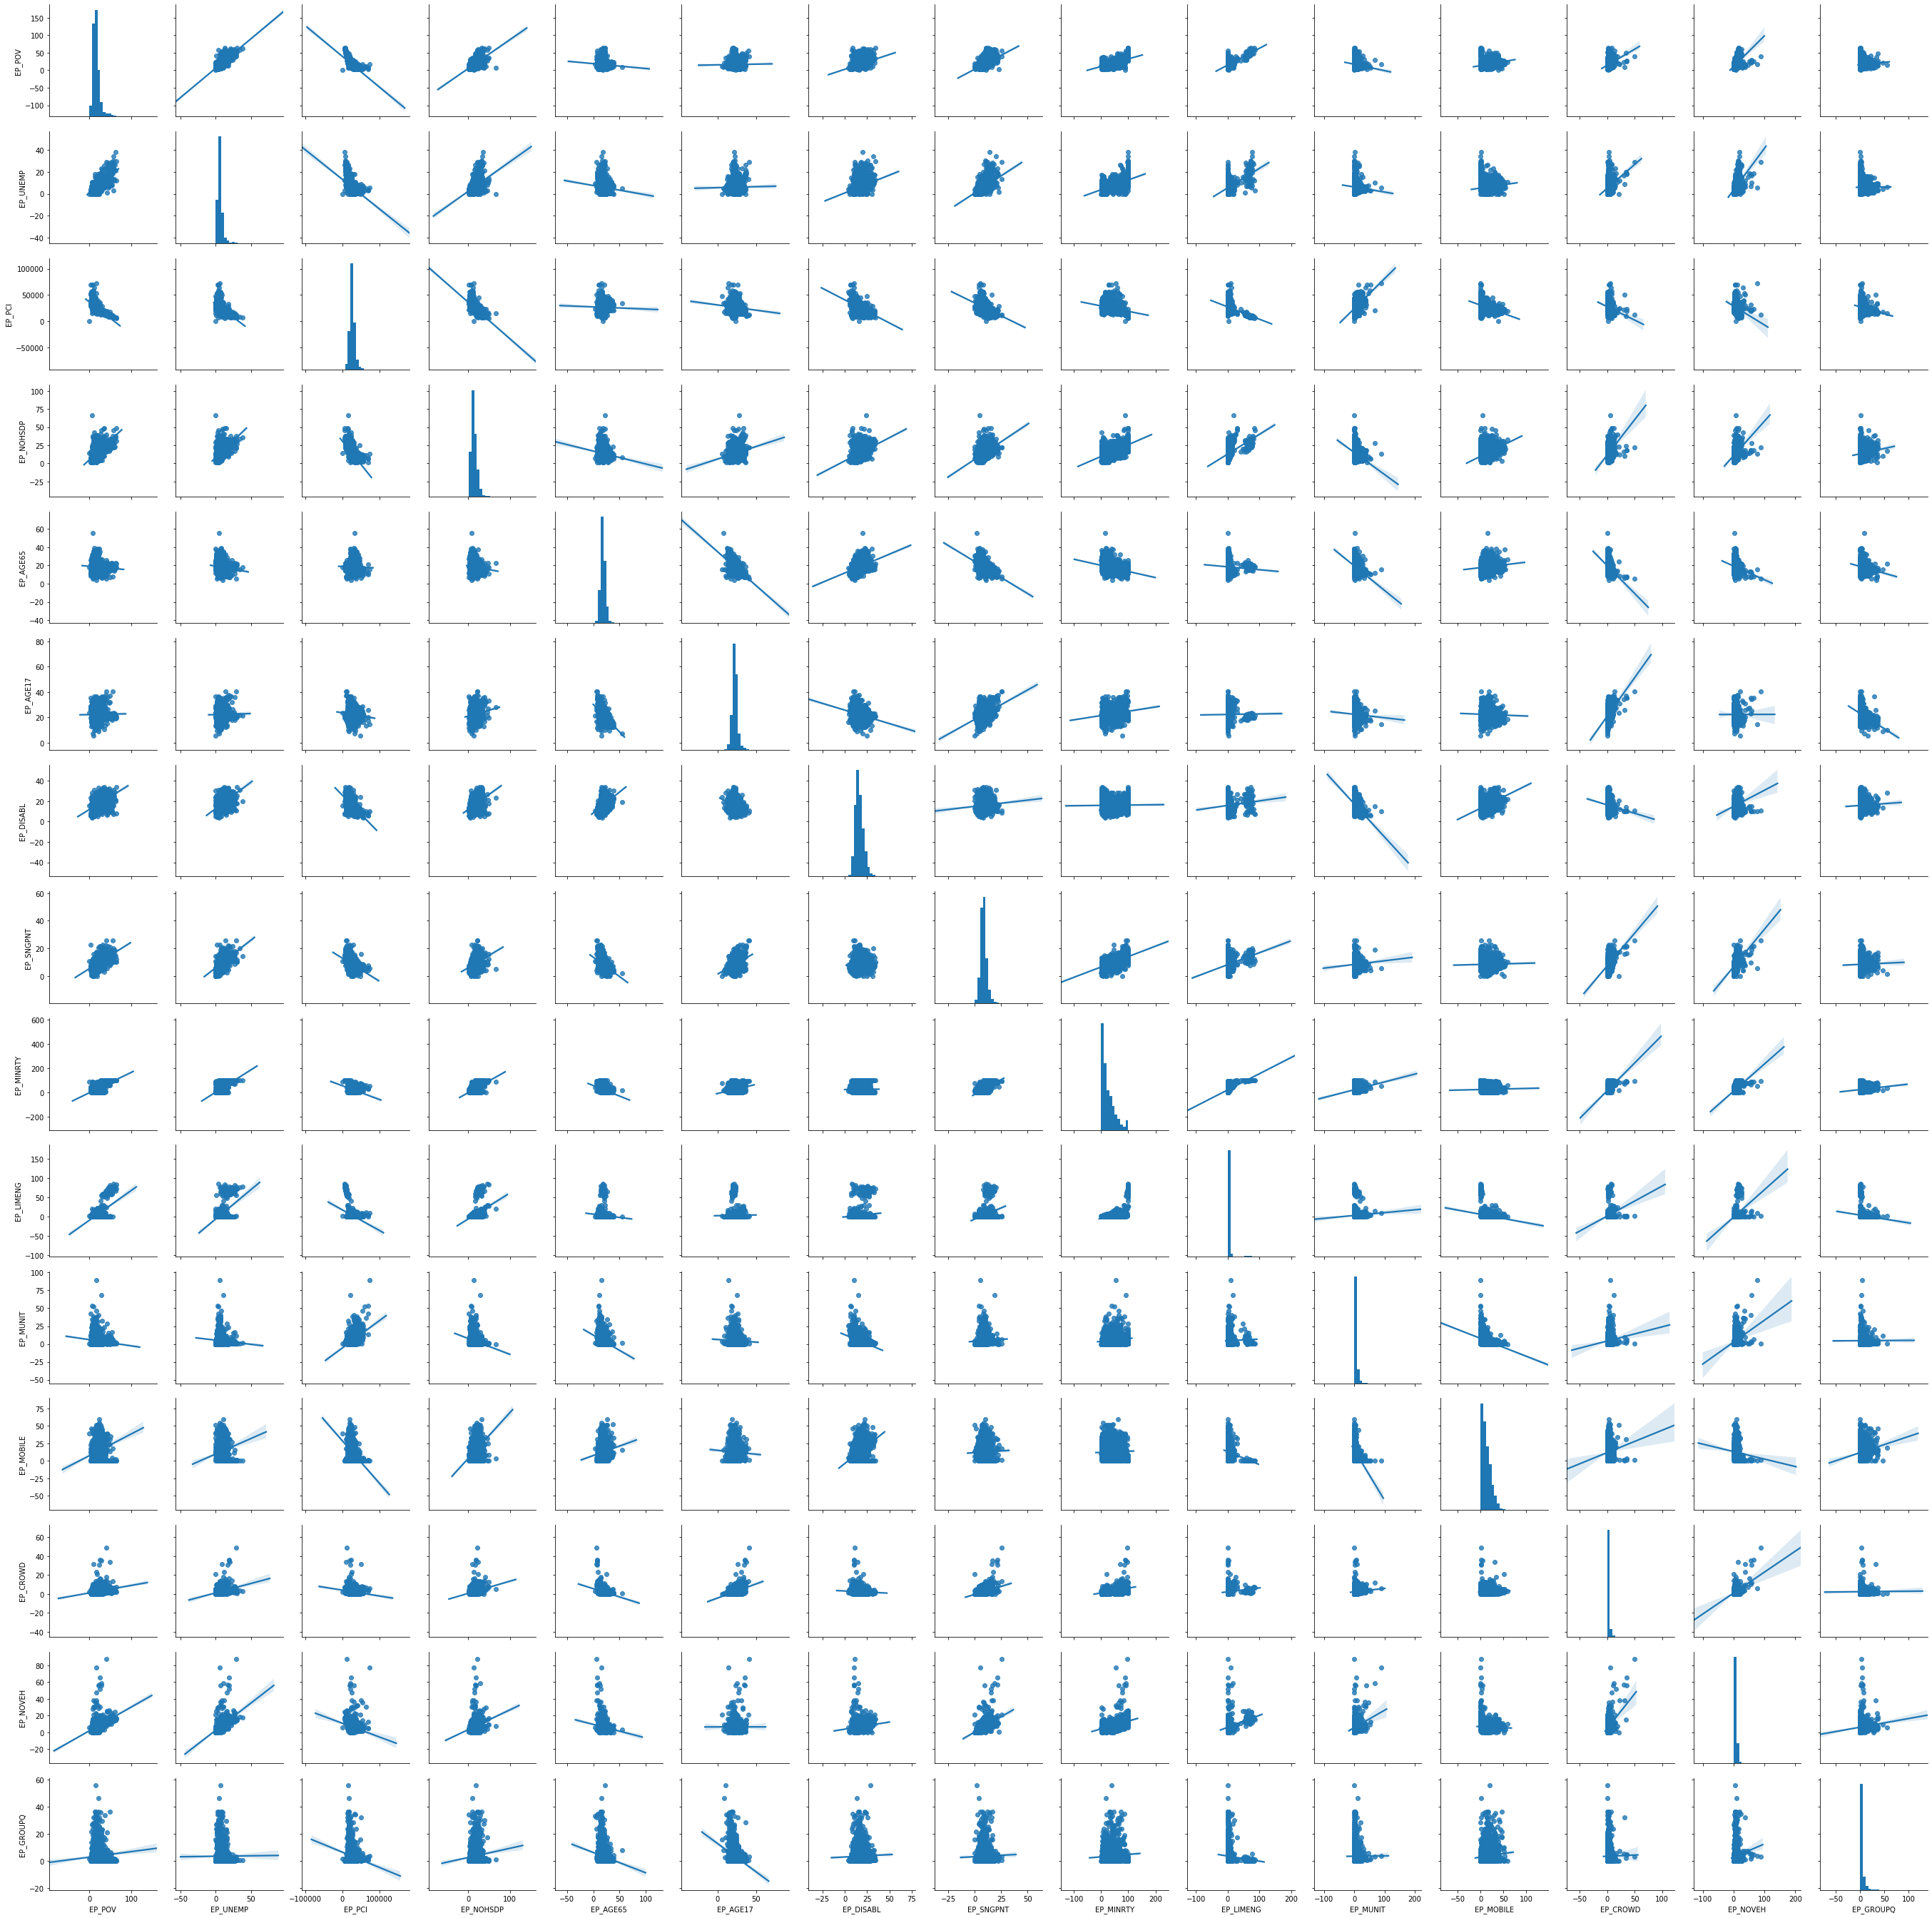

In [738]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

#for s in State:
    
#data_1 = svi_county.groupby('STATE').get_group(s)
data = svi_county[['EP_POV', 'EP_UNEMP', 'EP_PCI','EP_NOHSDP','EP_AGE65','EP_AGE17'
                   , 'EP_DISABL', 'EP_SNGPNT','EP_MINRTY', 'EP_LIMENG','EP_MUNIT', 'EP_MOBILE'
                   ,  'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ']]
sns.pairplot(data, kind="reg")
plt.show()

In [739]:



#for s in State:
    
 #   data_1 = svi_county.groupby('STATE').get_group(s)
#    data = data_1[['E_POV', 'E_UNEMP', 'E_PCI','E_NOHSDP','E_AGE65','E_AGE17'
#                   , 'E_DISABL', 'E_SNGPNT','E_MINRTY', 'E_LIMENG','E_MUNIT', 'E_MOBILE'
#                   ,  'E_CROWD', 'E_NOVEH', 'E_GROUPQ']]
    
  
 #   corr = data.corr()


  #  fig = plt.figure()
  #  ax = fig.add_subplot(111)
  #  cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
  #  fig.colorbar(cax)
  #  ticks = np.arange(0,len(data.columns),1)
  #  ax.set_xticks(ticks)
  #  plt.xticks(rotation=90)
  #  plt.text(5.7, -5.5, s + ' Correlation of variables', horizontalalignment='center') 
  #  ax.set_yticks(ticks)
  #  ax.set_xticklabels(data.columns)
  #  ax.set_yticklabels(data.columns)

   # plt.tight_layout()    
   # plt.show()
    #print (s)

    # print ( corr , '\n')

In [740]:
idx = pd.date_range(end='now', freq='M', periods = 3)
three_months = list(idx.month_name())


Minority_county = dict(zip(svi_county.FIPS, svi_county.RPL_THEME3))
Strategies = ["Medicaid",  "SVI"
              , "YPLL","Unemp", "Covid_last_14"]

fieldnames = []  
fieldnames.append('County_FIPS')




for s in Strategies:   
    #fieldnames.append('Proportional_allocation_to_' + s)
    fieldnames.append(s)
    #fieldnames.append('Normalized_' + s)

for m in three_months:
    fieldnames.append('Cum_Covid_death_in_'+ m)
#fieldnames.append("Minority")    
        
County_state = {}
Medicaid_demand_state = {}
County_demand_state = {} 
SVI_county_state = {}
YPLL_state = {}
Unemployment_state = {}
Covid_capita_state = {}
Covid_death_capita_state = {}
Three_month_lag_covid_death_capita_state = {}
Two_month_lag_covid_death_capita_state = {}
One_month_lag_covid_death_capita_state = {}
#Minority_county_state = {}

for s in State:
              
    County_state[s] = {j: j  for j in location if (j,s) in cartesian_pro_county_state }
    
    Medicaid_demand_state[s] =  {j: Medicaid_capita[j] for j in location if (j,s) in cartesian_pro_county_state } 
    
    SVI_county_state [s] =  {j: SVI_county[j] for j in location if (j,s) in cartesian_pro_county_state } 
    
    YPLL_state [s] = {j: YPLL[j] for j in location if (j,s) in cartesian_pro_county_state }
    
    Unemployment_state [s] =  {j:  Unemployment_capita[j] for j in location if (j,s) in cartesian_pro_county_state }
    
    Covid_capita_state [s] = {j: Covid_capita[j] for j in location if (j,s) in cartesian_pro_county_state } 
    
    #Covid_death_capita_state [s] = {j: Covid_death_capita[j] for j in location if (j,s) in cartesian_pro_county_state }
    
    Three_month_lag_covid_death_capita_state [s] = {j: Three_month_lag_covid_death_capita[j] for j in location if (j,s) in cartesian_pro_county_state }
    
    Two_month_lag_covid_death_capita_state [s] = {j: Two_month_lag_covid_death_capita[j] for j in location if (j,s) in cartesian_pro_county_state }
    
    One_month_lag_covid_death_capita_state [s] = {j: One_month_lag_covid_death_capita[j] for j in location if (j,s) in cartesian_pro_county_state }
    
    #Minority_county_state [s] =  {j: Minority_county[j] for j in location if (j,s) in cartesian_pro_county_state }
      
                      #Medicaid_capita.values()
                      #  COVID_14days.values()
                      #     SVI_county.values()
                      #        YPLL.values()

                      #Unemployment_capita.values()
                     #Covid_capita.values()      
                    #Covid_death_capita.values()      

for s in State:
    writefile = 'Output/County_level_values_'+ s +'.csv'
    with open( writefile, 'w' ) as f:
        writer = csv.writer(f)                
        writer.writerow(fieldnames)
        for row in zip(County_state[s].values()
                       , Medicaid_demand_state[s].values() 
                       , SVI_county_state[s].values()
                       , YPLL_state[s].values()
                       , Unemployment_state[s].values()
                       , Covid_capita_state[s].values()
                       #, Covid_death_capita_state[s].values()
                       #, Minority_county_state[s].values()
                       ,Three_month_lag_covid_death_capita_state[s].values()
                       ,Two_month_lag_covid_death_capita_state[s].values()
                       ,One_month_lag_covid_death_capita_state[s].values()
                      ):                    

            writer.writerow(row)

In [741]:
from scipy import stats
#for s in State:
#    print (s)
#    data = pd.read_csv('Output/County_level_values_'+ s +'.csv', index_col=0)
#    sns_plot = sns.pairplot(data)
#    plt.show()
#    sns_plot.savefig('Output/Pairplot_' + s +'.png')

from scipy import stats

for s in State:
    
    data = pd.read_csv('Output/County_level_values_'+ s +'.csv', index_col=0)
    corr = data.corr()
    
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    plt.text(2.7, -2.5, s + ' Correlation of variables', horizontalalignment='center') 
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    
    plt.tight_layout() 
    print (s)
    
    plt.show()
    
    fig.savefig('Output/Corr_plot_' + s +'.png')
   
    #print ( corr , '\n')

In [742]:
#for s in State:
#    if s != "DISTRICT OF COLUMBIA":
#        print (s)
    
#        data = pd.read_csv('Output/County_level_values_'+ s +'.csv', index_col=0)
#        sns.pairplot(data, kind="reg")
#        plt.show()

In [743]:
count = 0
Number_of_county_per_State = {}
for s in State:
    for j in location:
        if (j,s) in cartesian_pro_county_state:
            count += 1
    Number_of_county_per_State[s] = count
    count = 0
#print (Number_of_county_per_State)

sort_orders = sorted(Number_of_county_per_State.items(), key=lambda x: x[1], reverse=True)

print (sort_orders)

[('TEXAS', 254), ('GEORGIA', 159), ('VIRGINIA', 133), ('KENTUCKY', 120), ('MISSOURI', 115), ('KANSAS', 105), ('ILLINOIS', 102), ('NORTH CAROLINA', 100), ('IOWA', 99), ('TENNESSEE', 95), ('NEBRASKA', 93), ('INDIANA', 92), ('OHIO', 88), ('MINNESOTA', 87), ('MICHIGAN', 83), ('MISSISSIPPI', 82), ('PUERTO RICO', 78), ('OKLAHOMA', 77), ('ARKANSAS', 75), ('WISCONSIN', 72), ('ALABAMA', 67), ('FLORIDA', 67), ('PENNSYLVANIA', 67), ('SOUTH DAKOTA', 66), ('COLORADO', 64), ('LOUISIANA', 64), ('NEW YORK', 62), ('CALIFORNIA', 58), ('MONTANA', 56), ('WEST VIRGINIA', 55), ('NORTH DAKOTA', 53), ('SOUTH CAROLINA', 46), ('IDAHO', 44), ('WASHINGTON', 39), ('OREGON', 36), ('NEW MEXICO', 33), ('ALASKA', 29), ('UTAH', 29), ('MARYLAND', 24), ('WYOMING', 23), ('NEW JERSEY', 21), ('NEVADA', 17), ('MAINE', 16), ('ARIZONA', 15), ('MASSACHUSETTS', 14), ('VERMONT', 14), ('NEW HAMPSHIRE', 10), ('CONNECTICUT', 8), ('RHODE ISLAND', 5), ('HAWAII', 5), ('DELAWARE', 3), ('DISTRICT OF COLUMBIA', 1)]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions

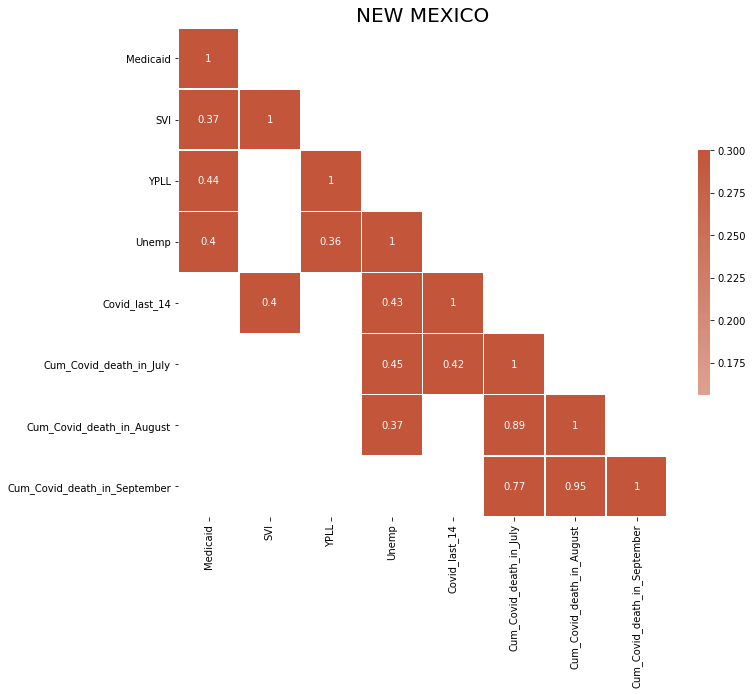

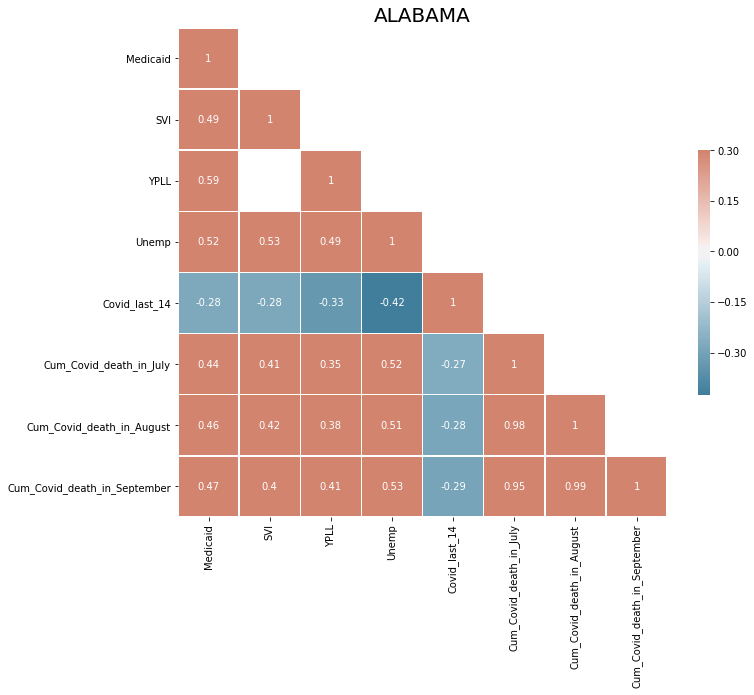

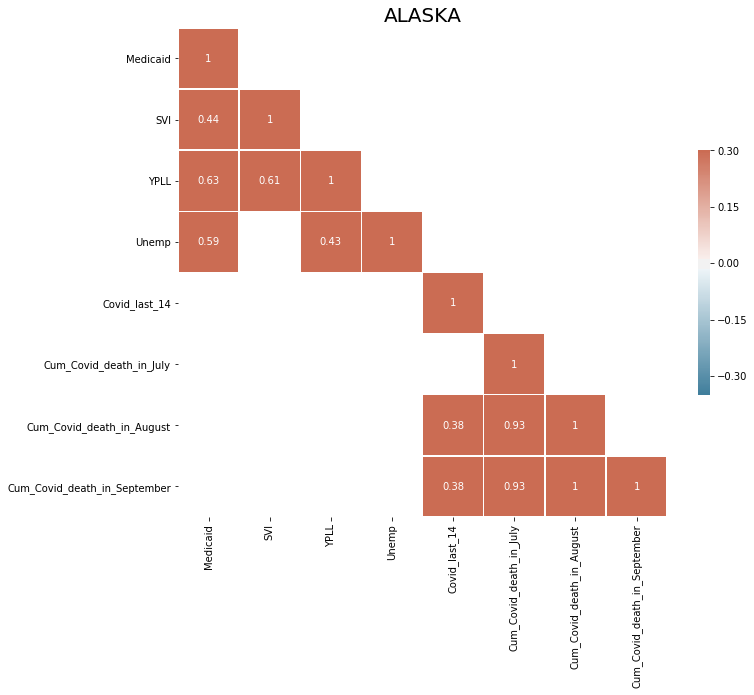

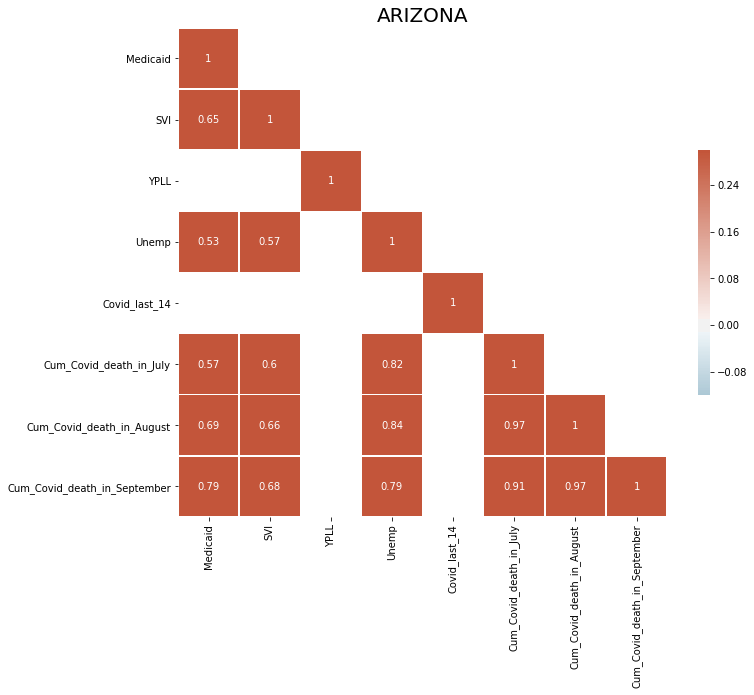

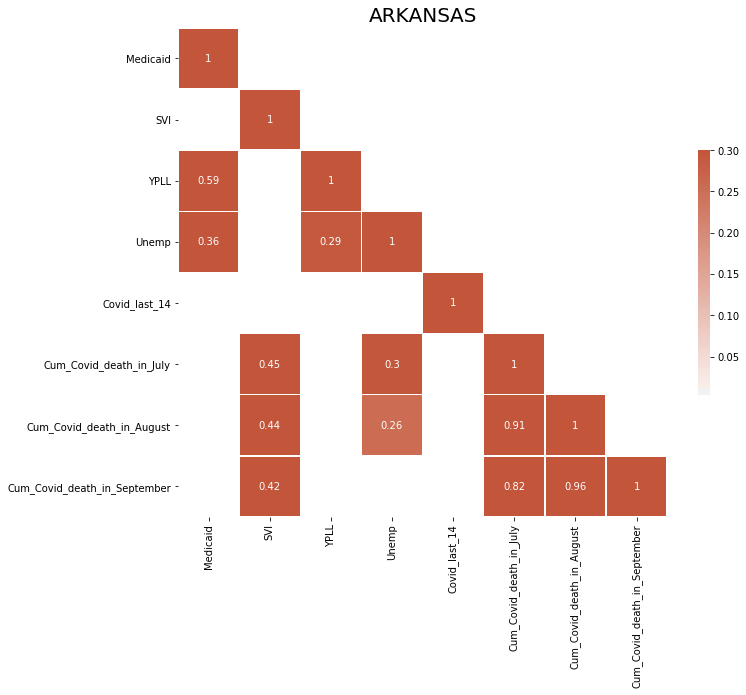

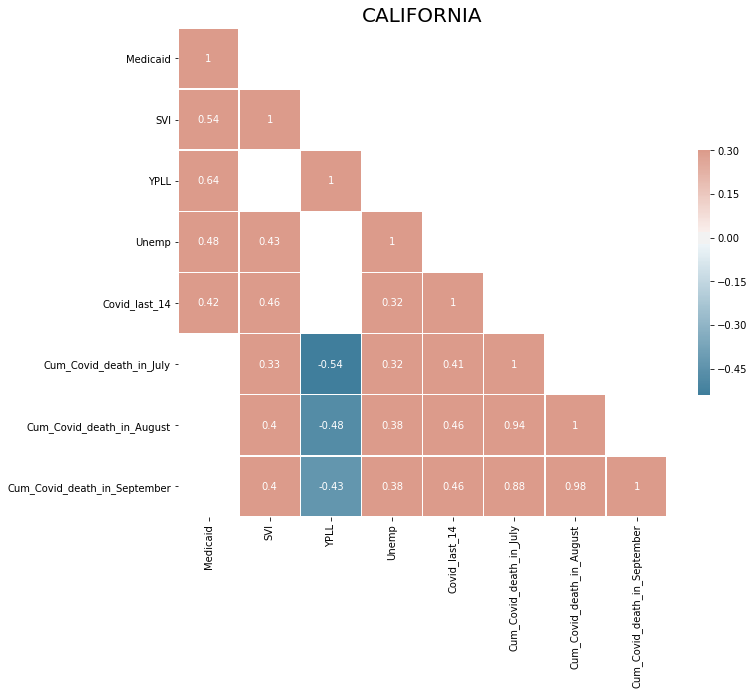

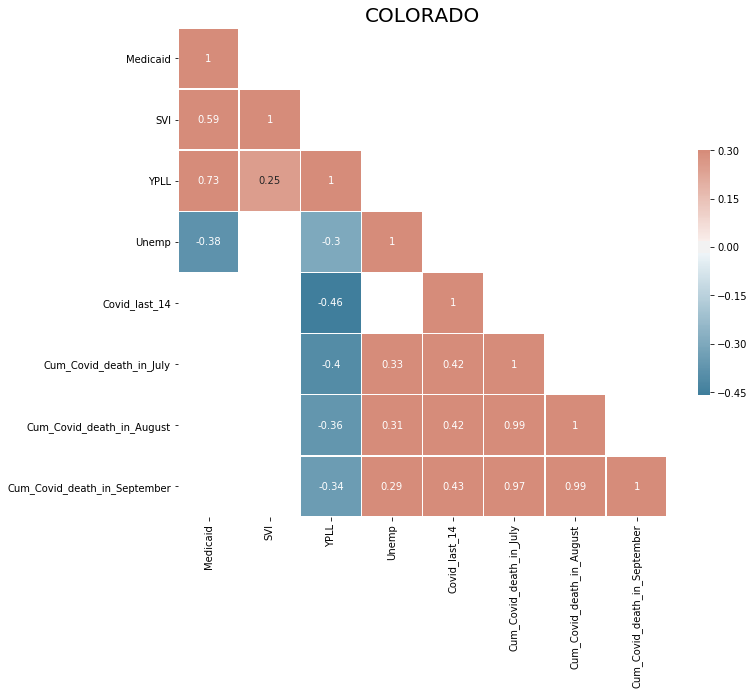

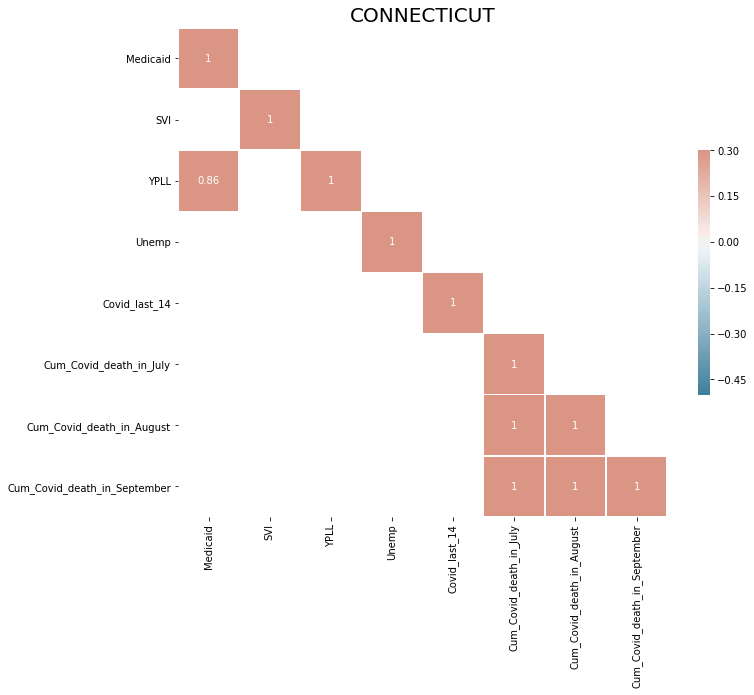

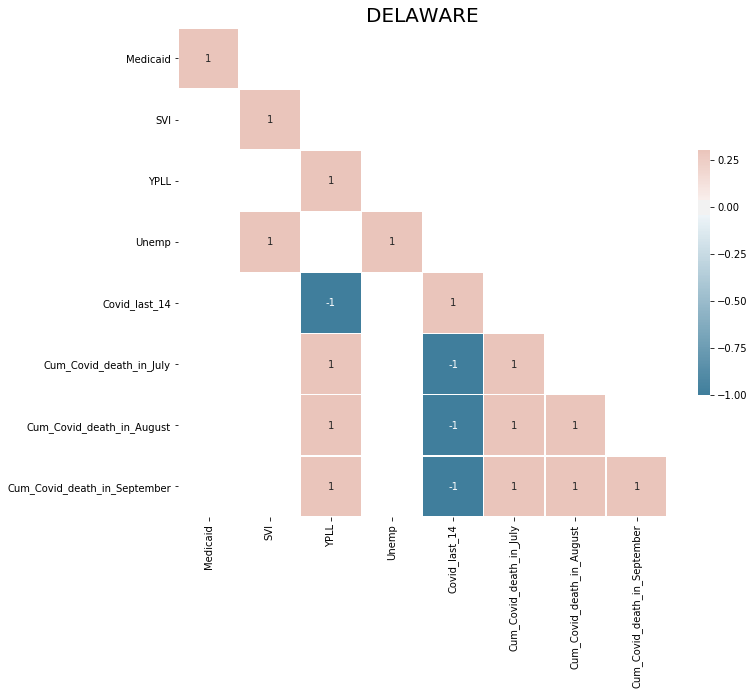

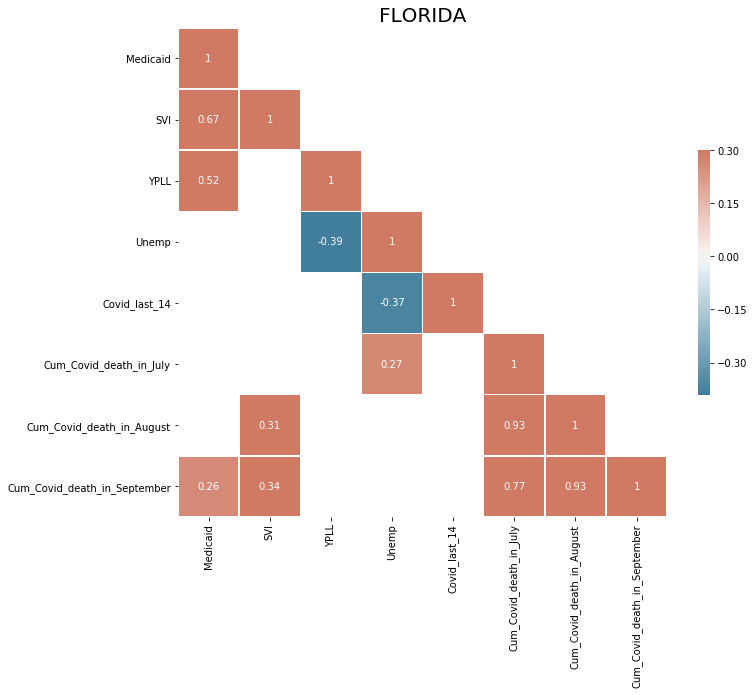

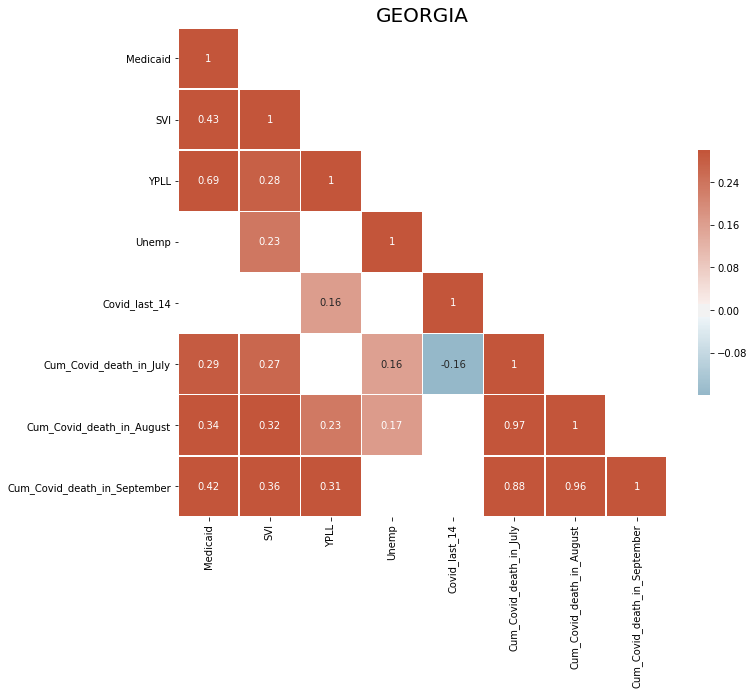

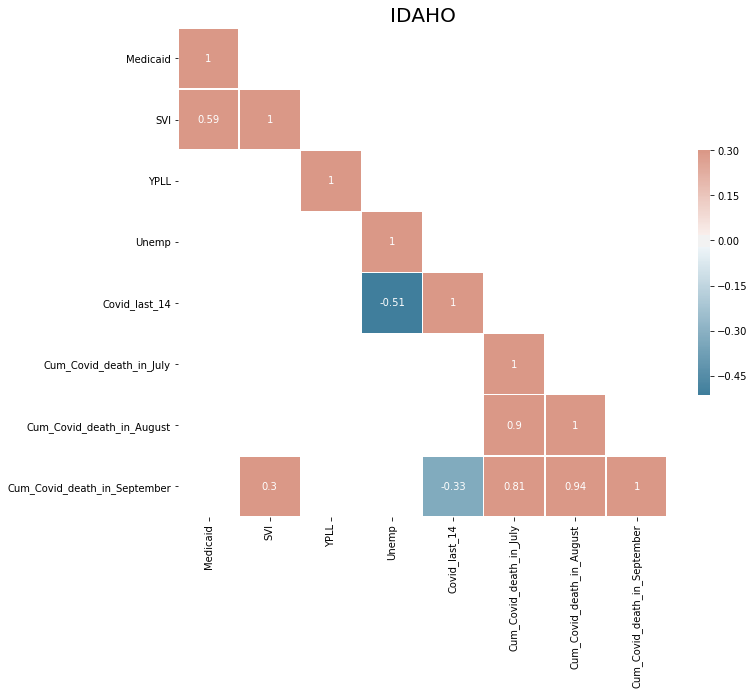

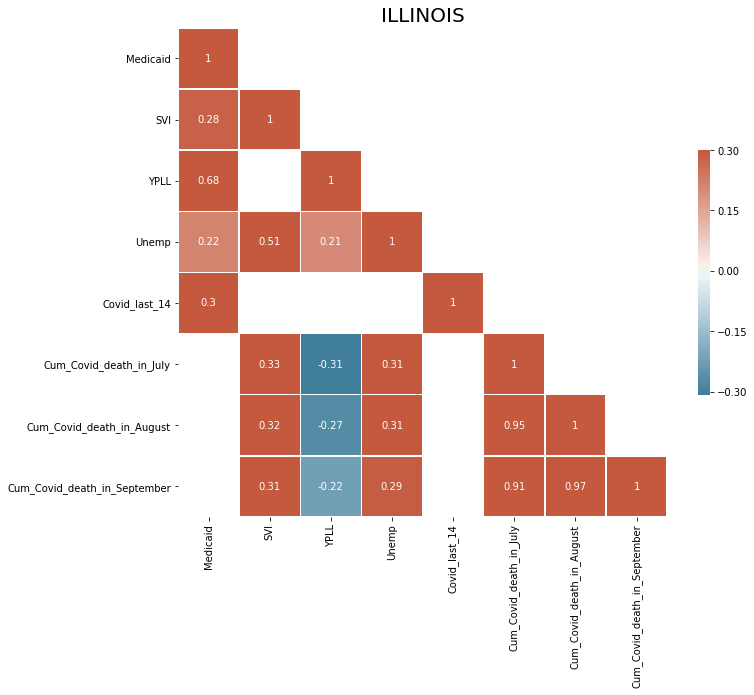

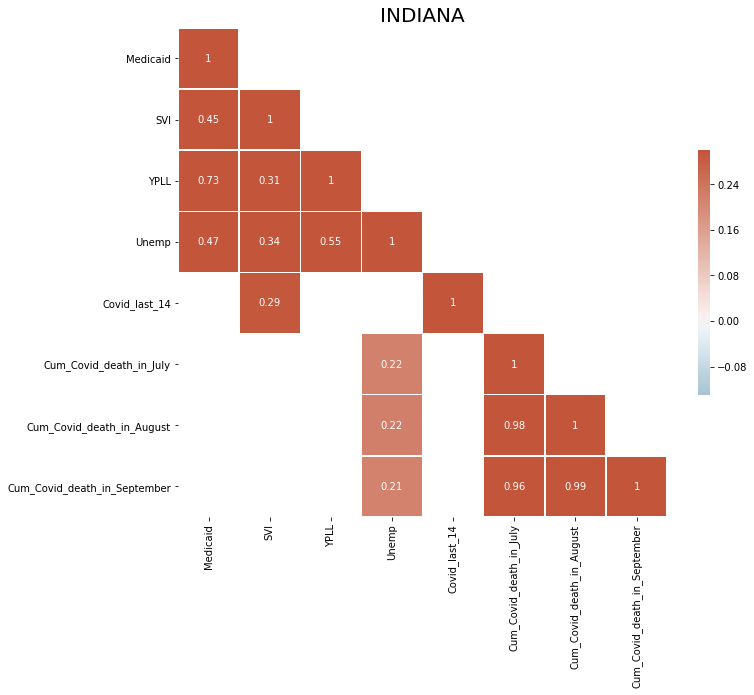

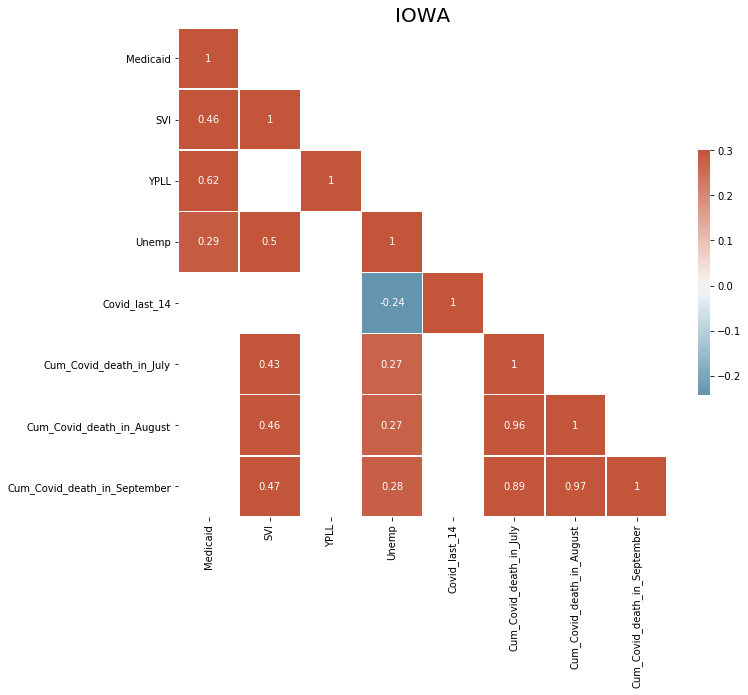

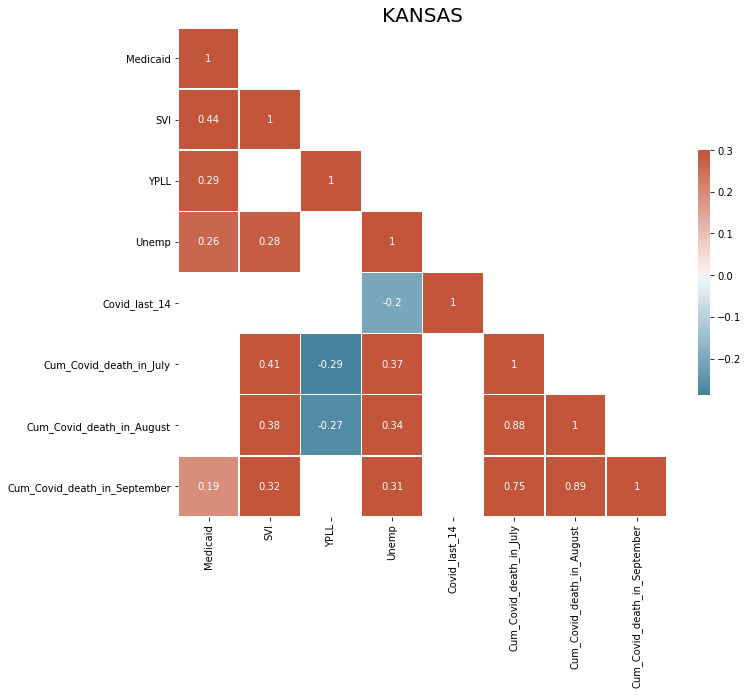

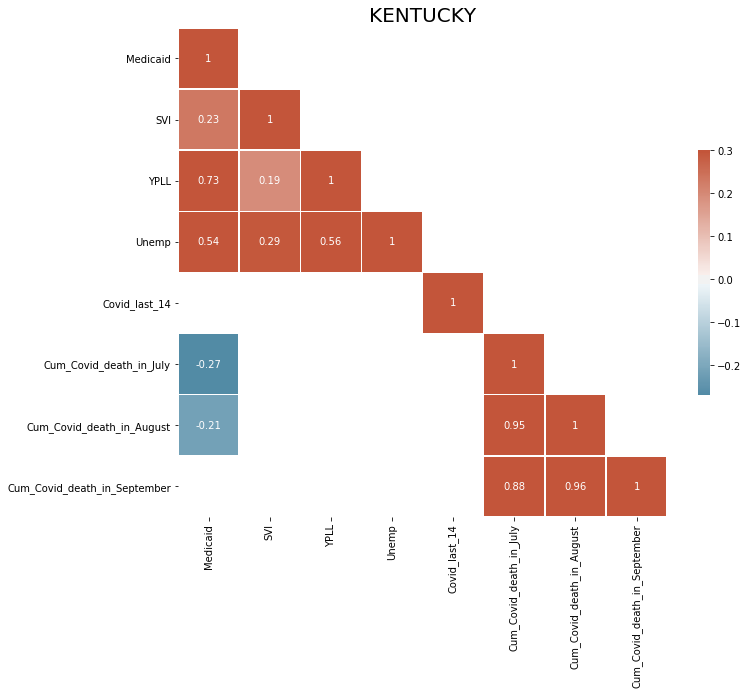

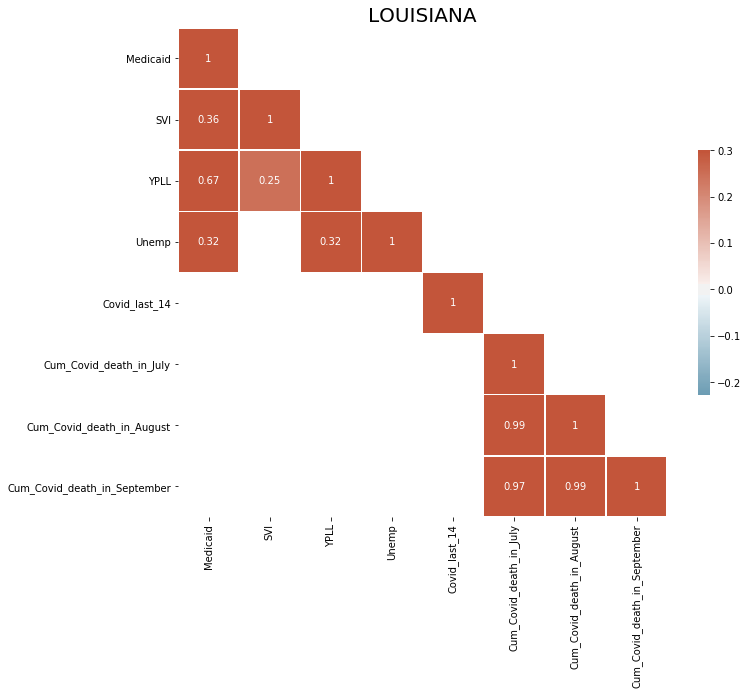

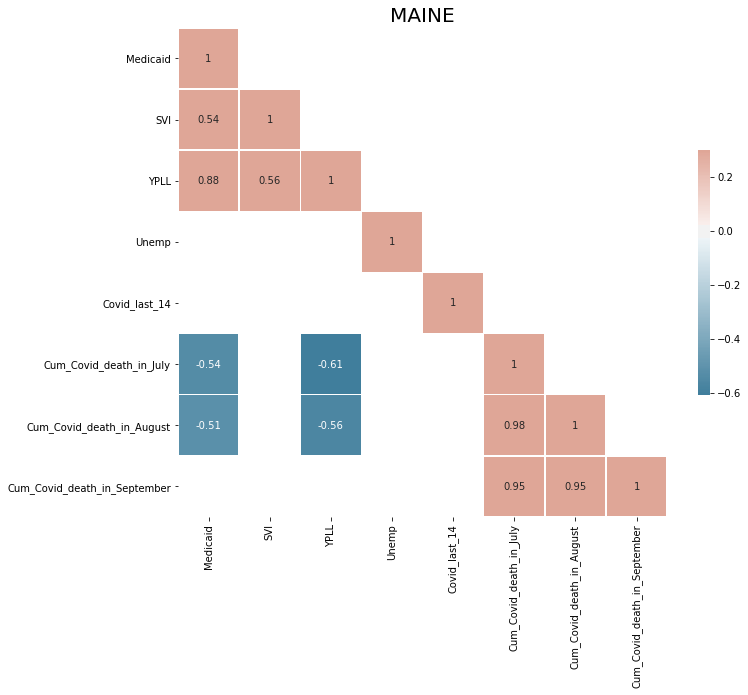

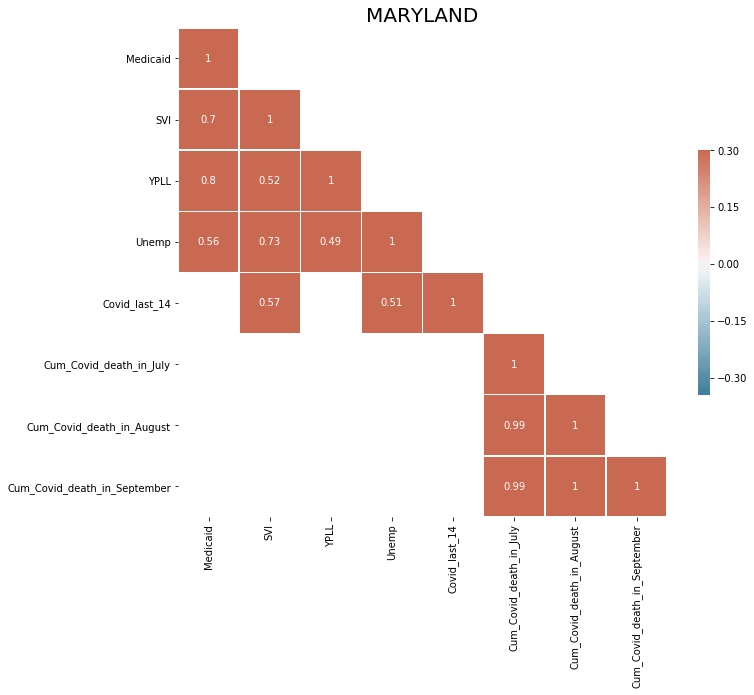

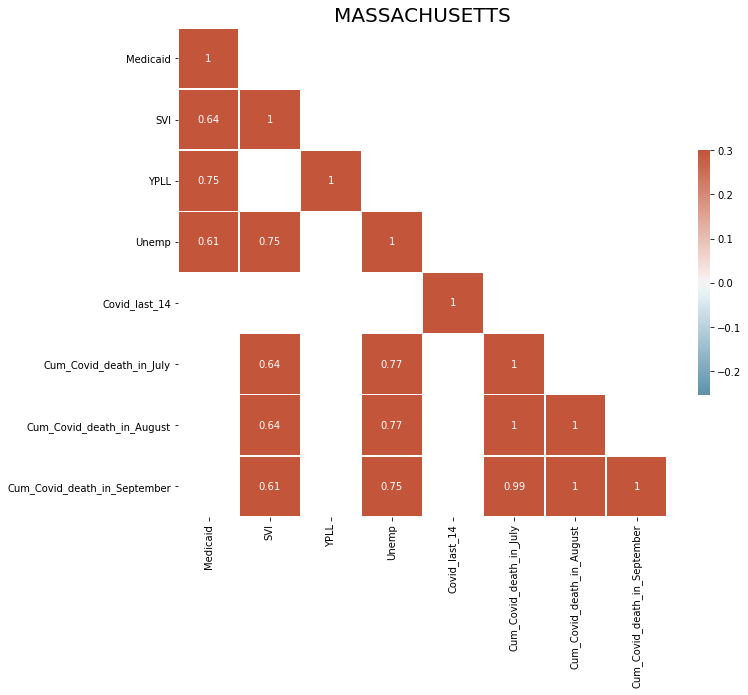

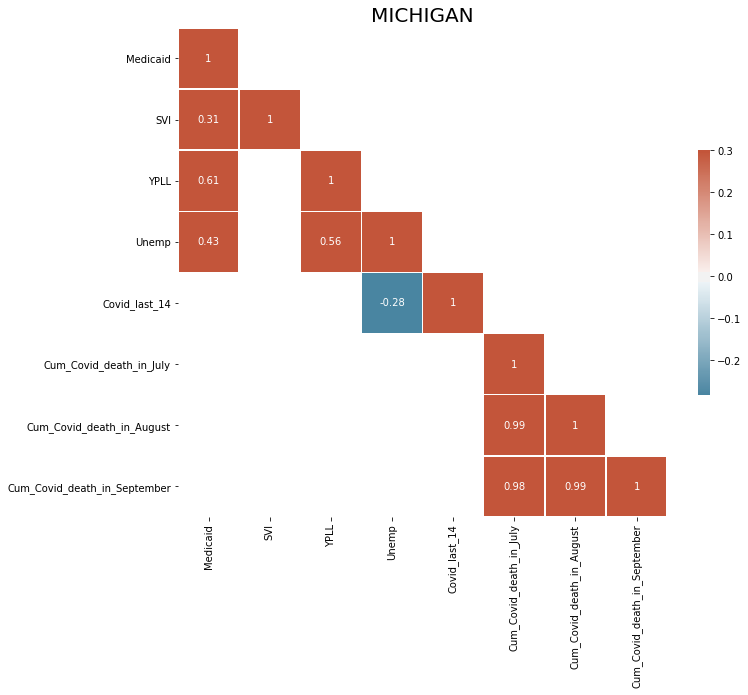

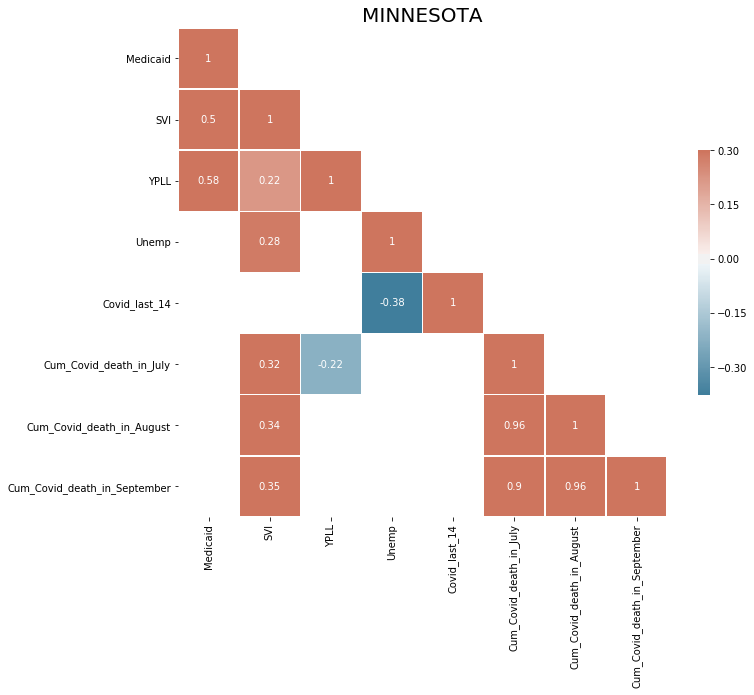

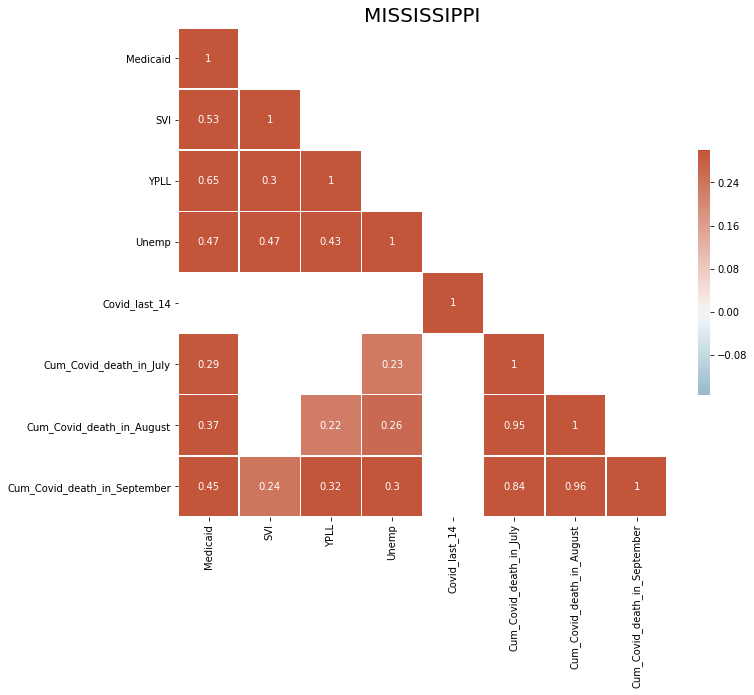

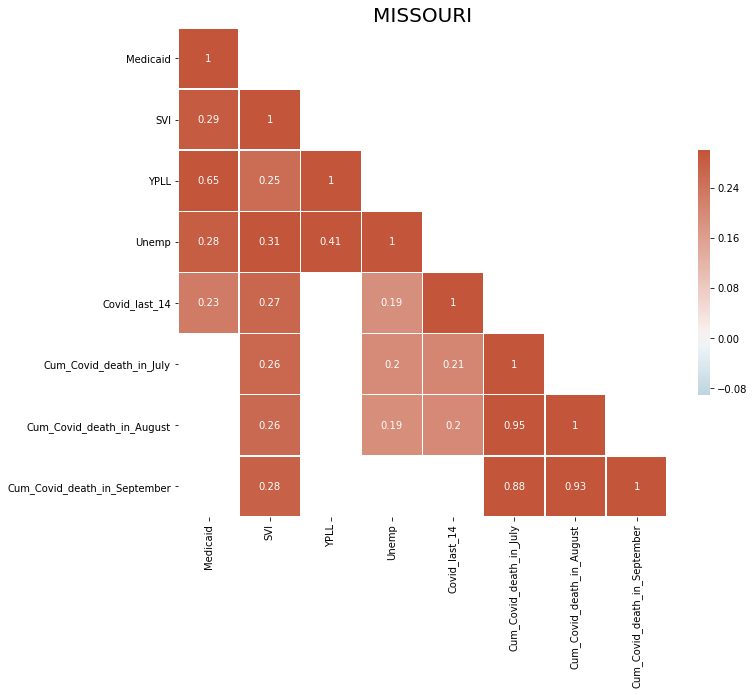

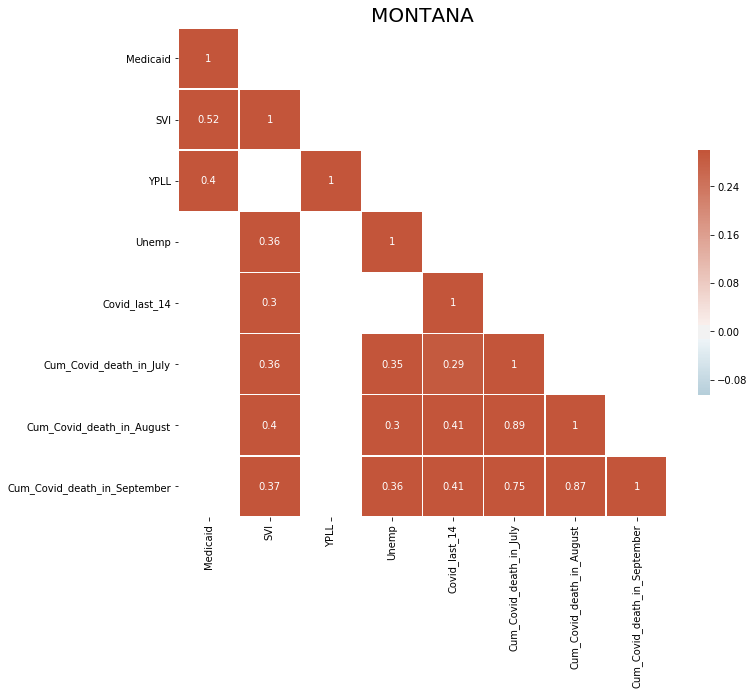

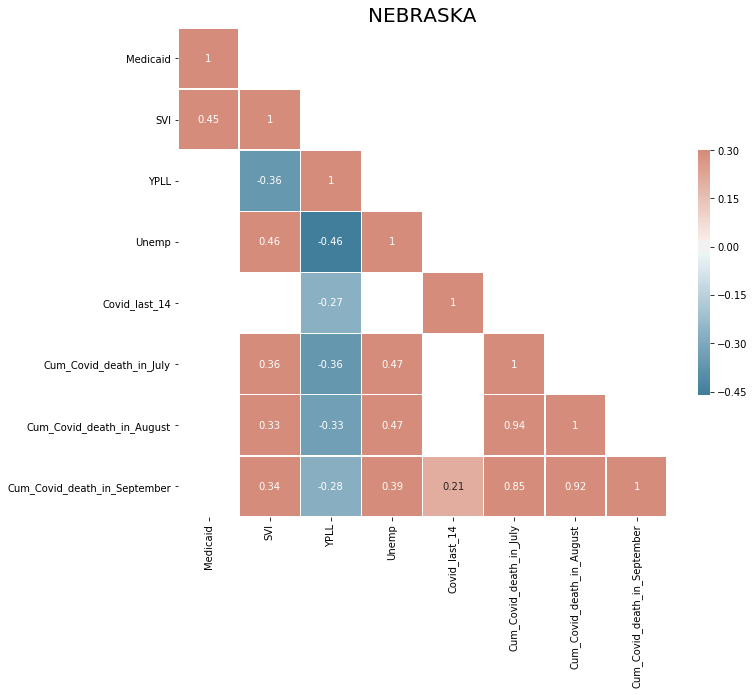

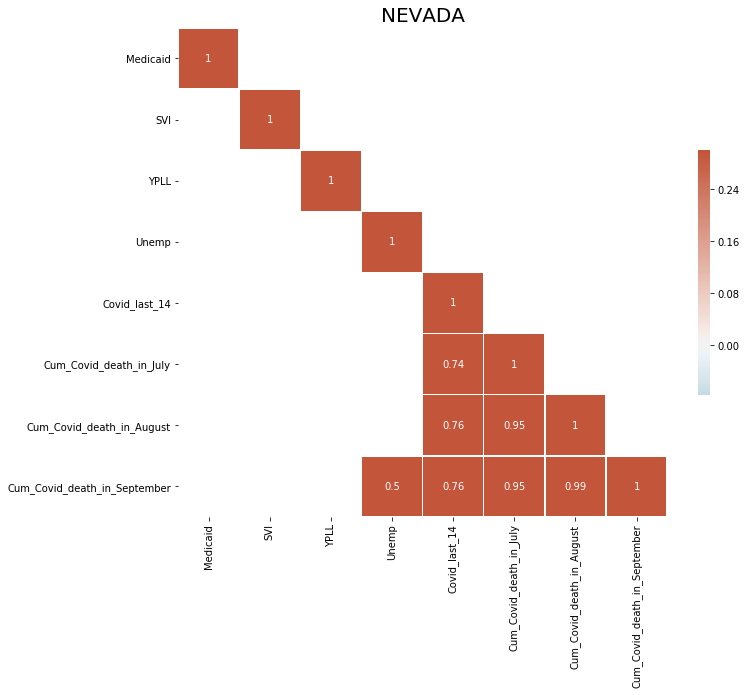

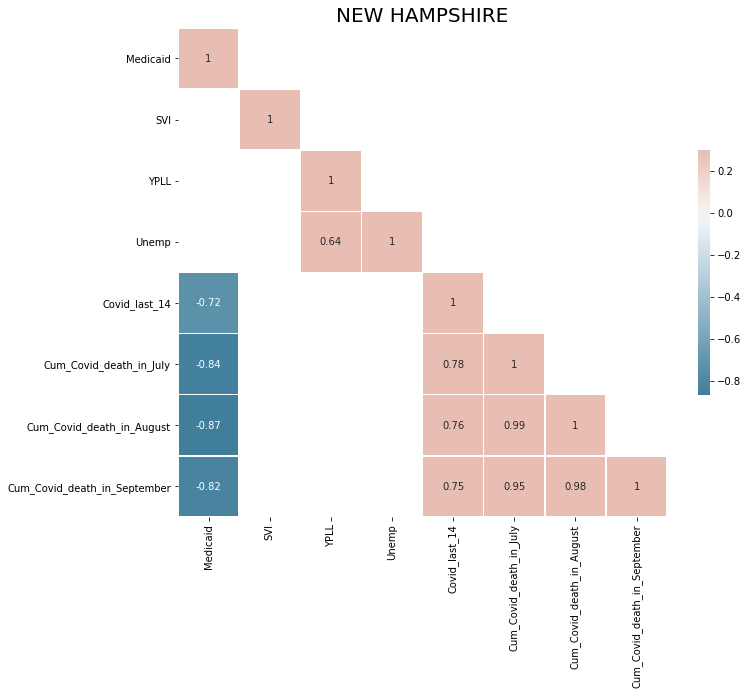

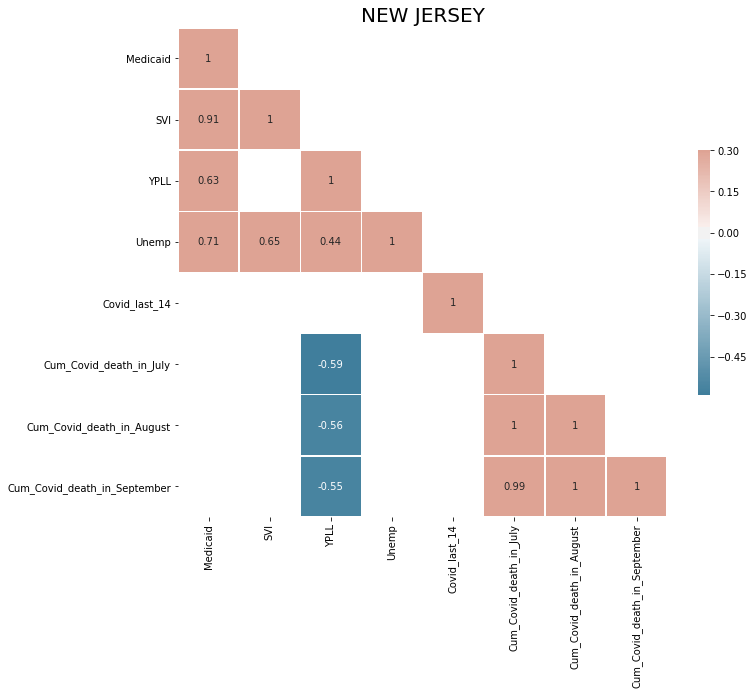

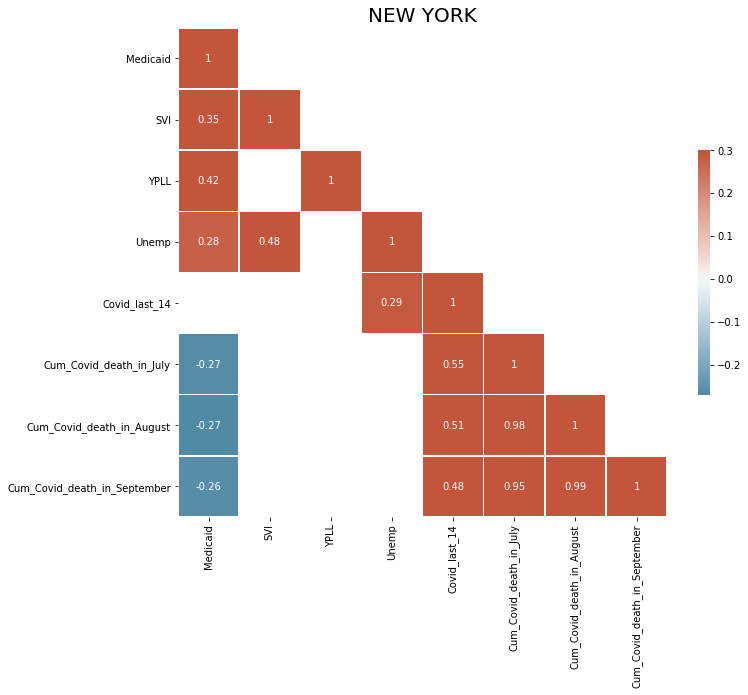

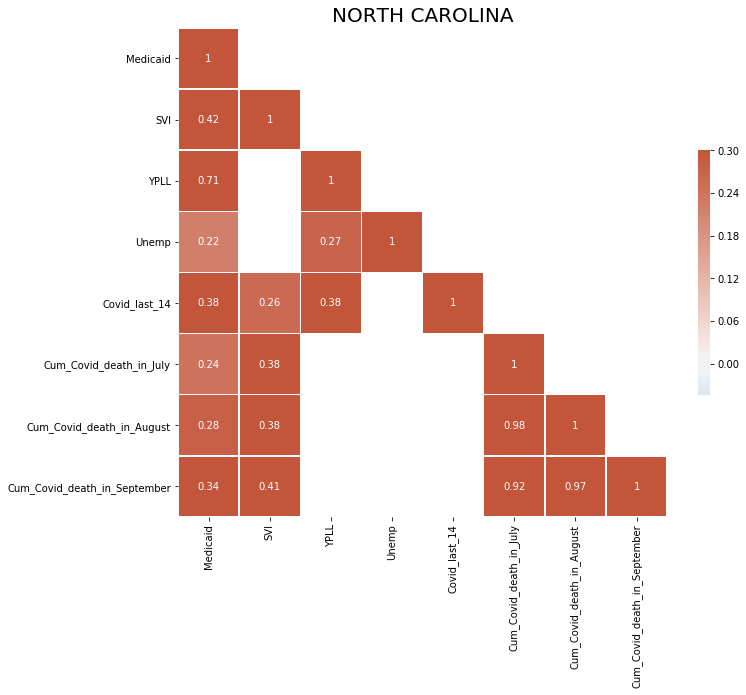

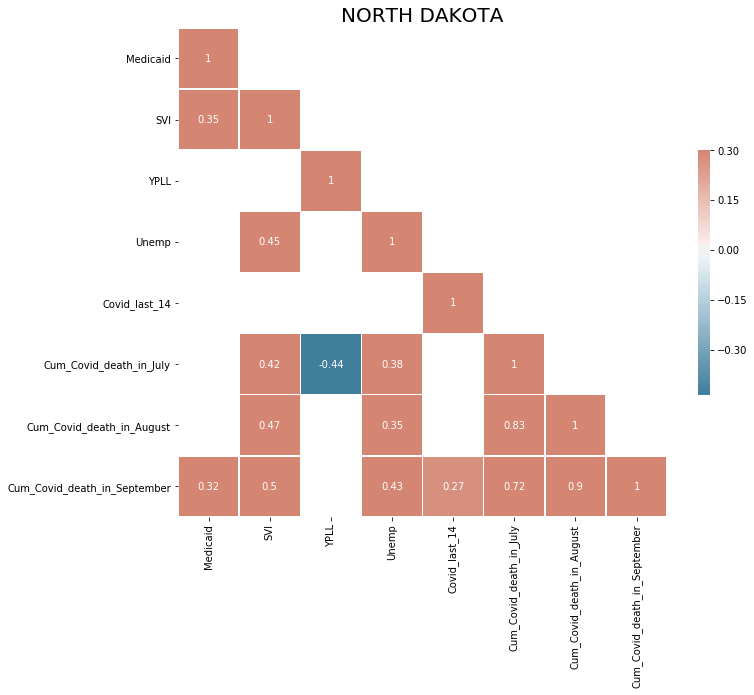

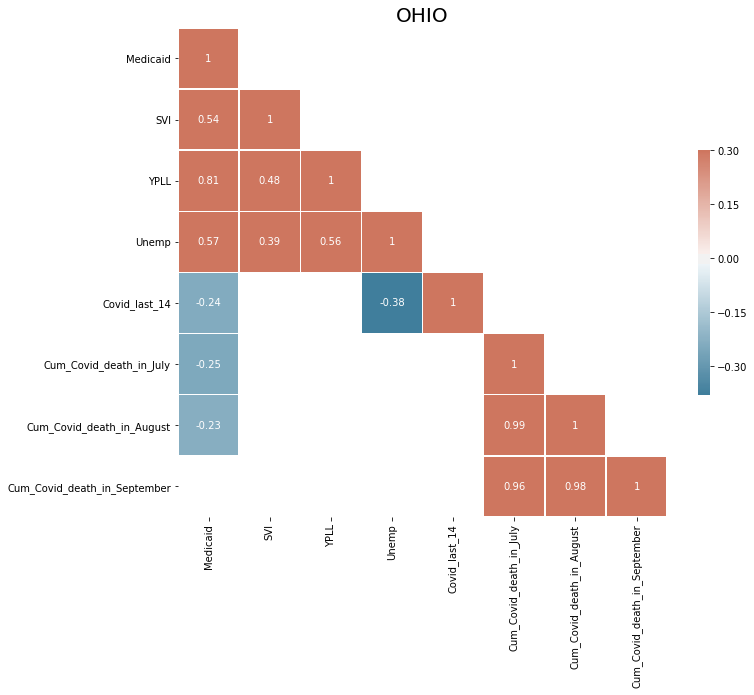

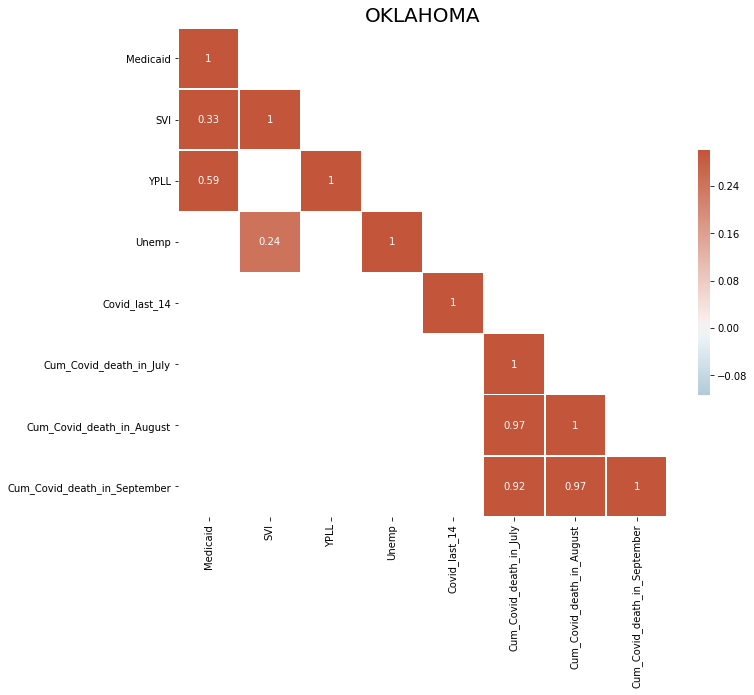

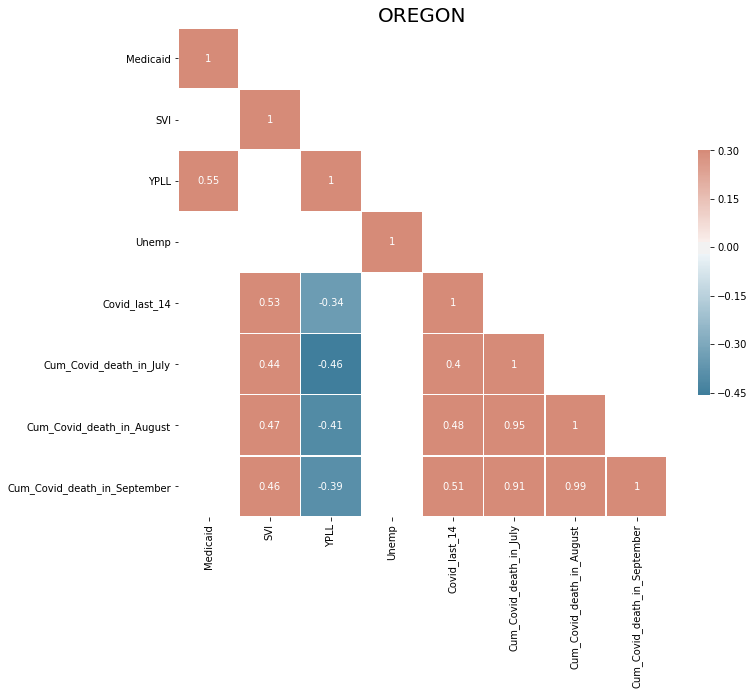

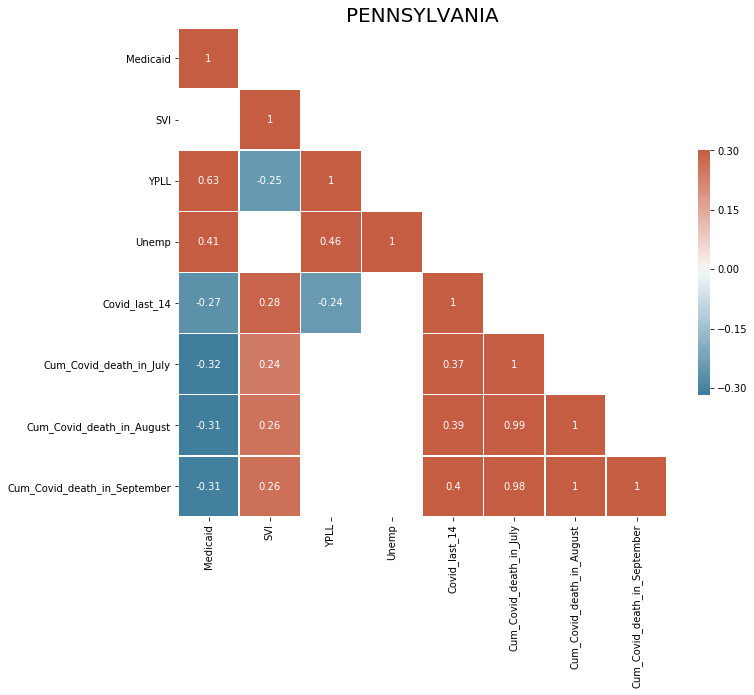

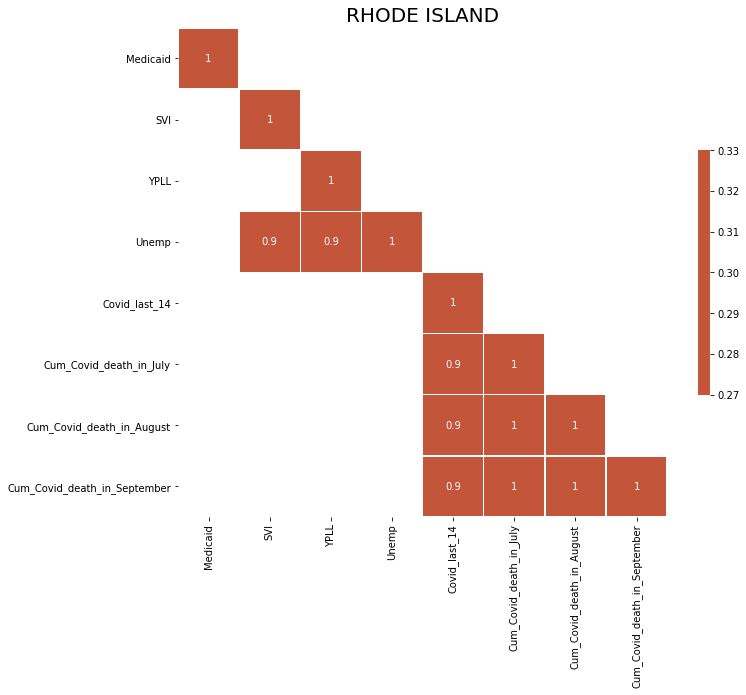

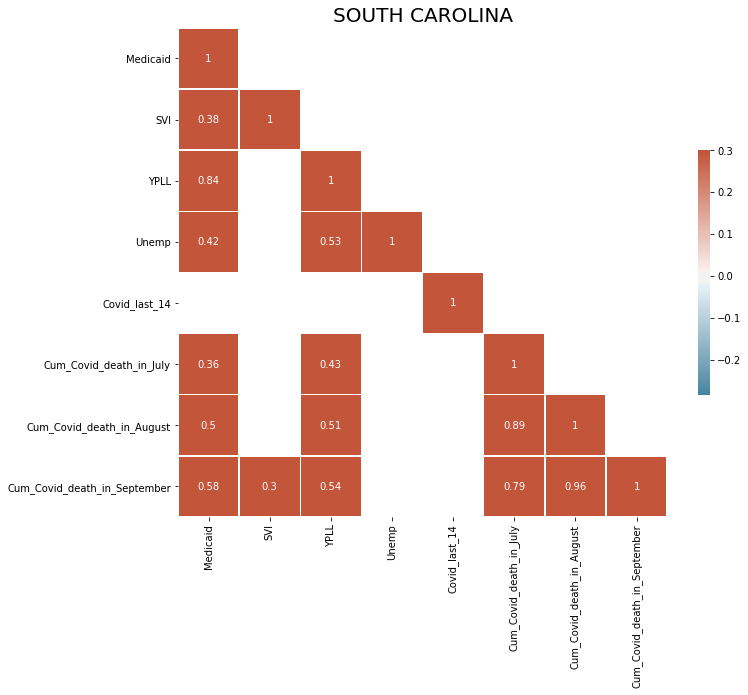

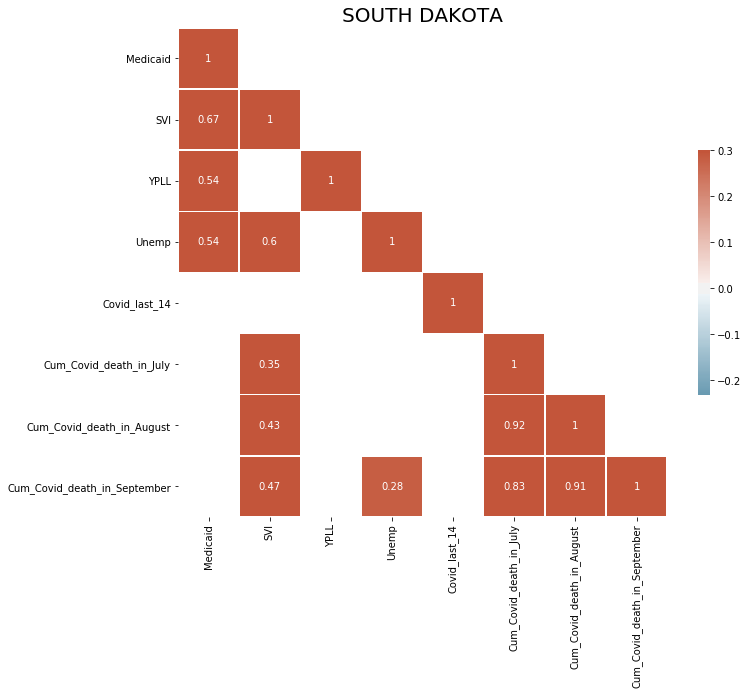

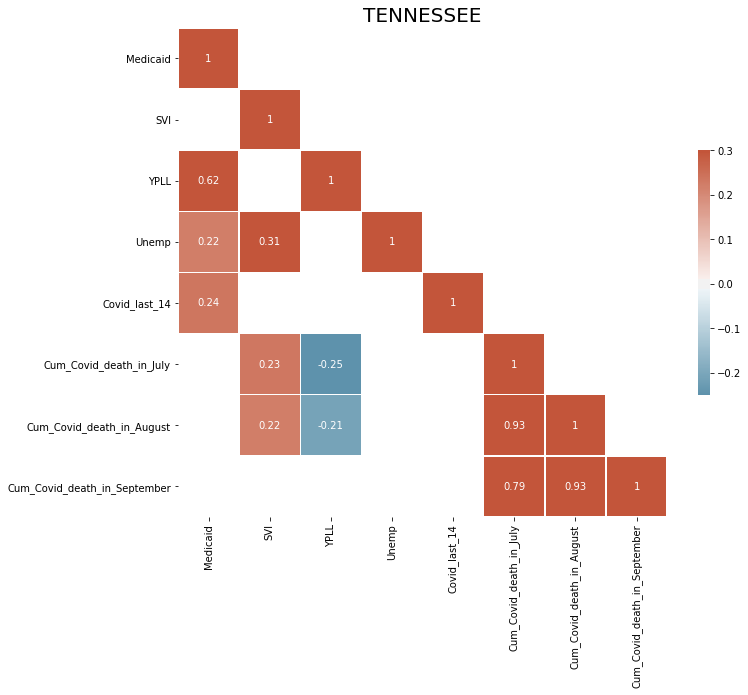

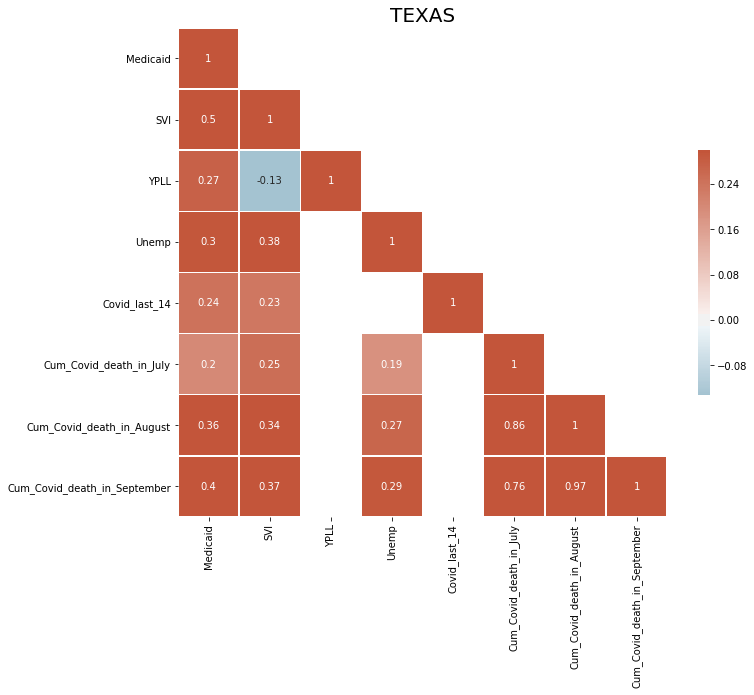

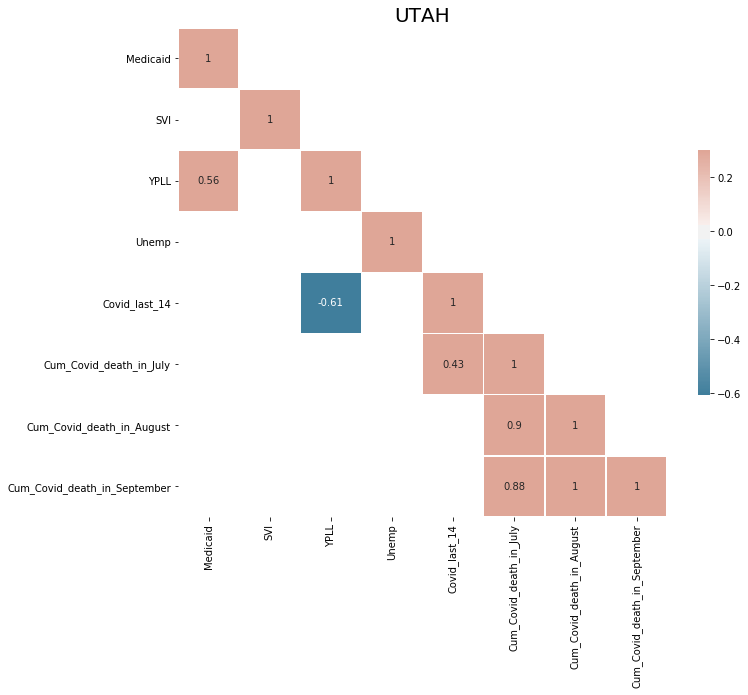

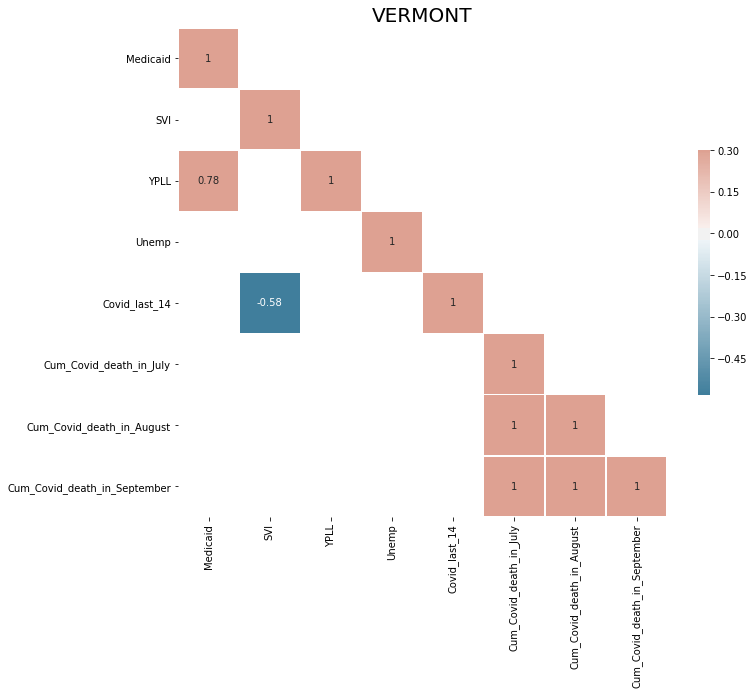

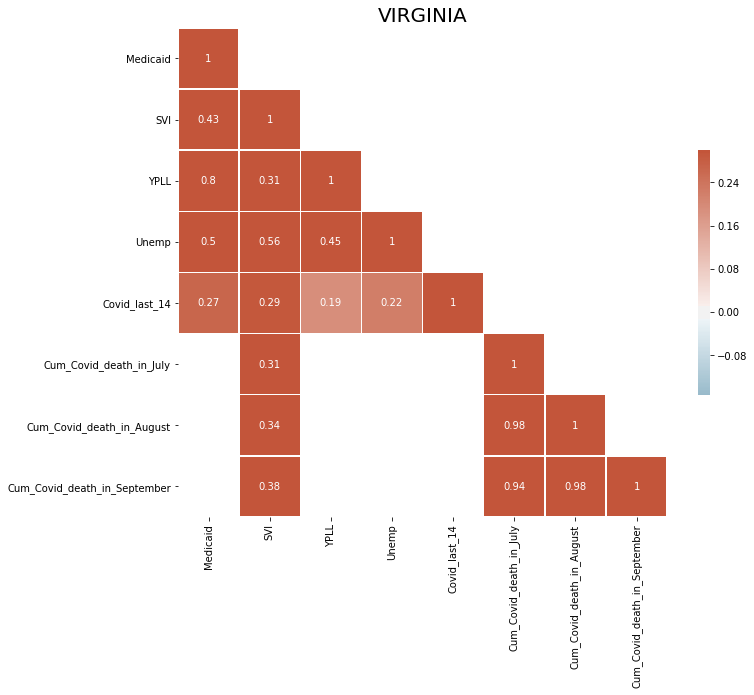

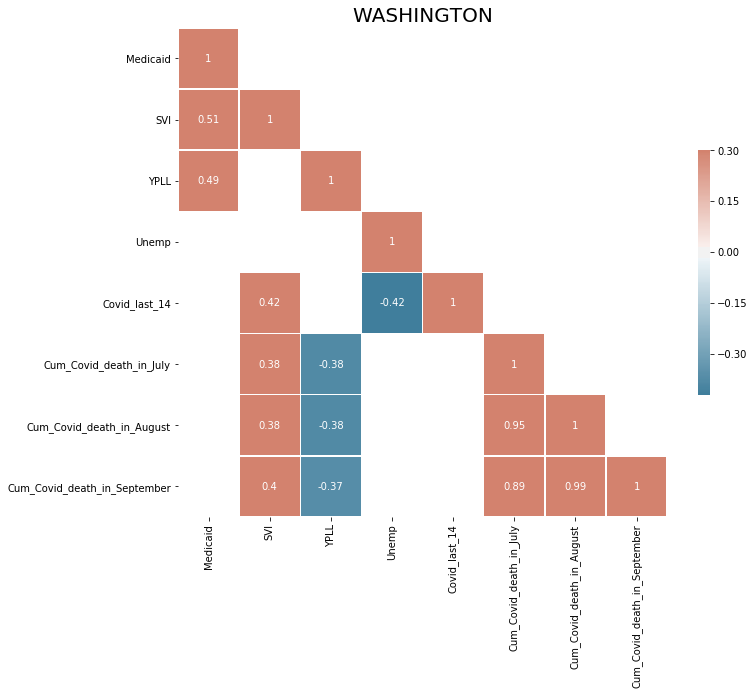

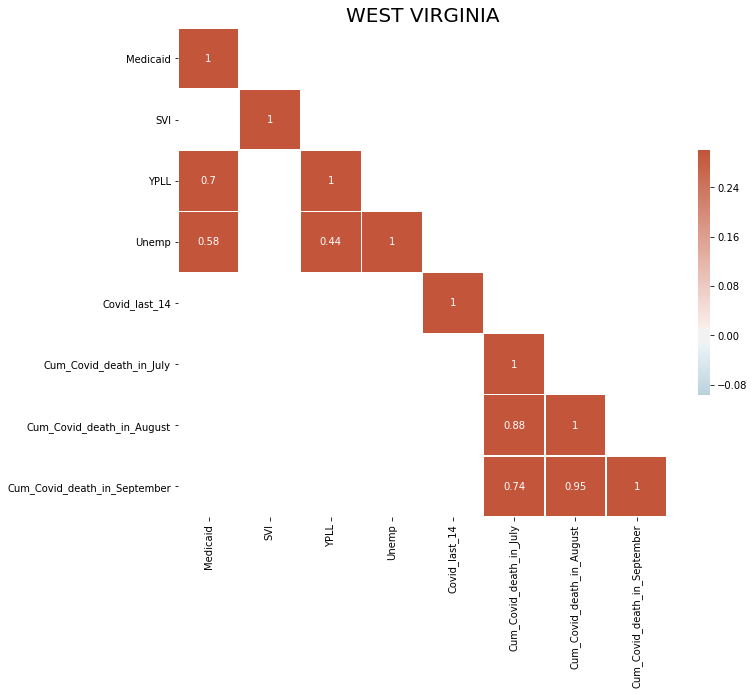

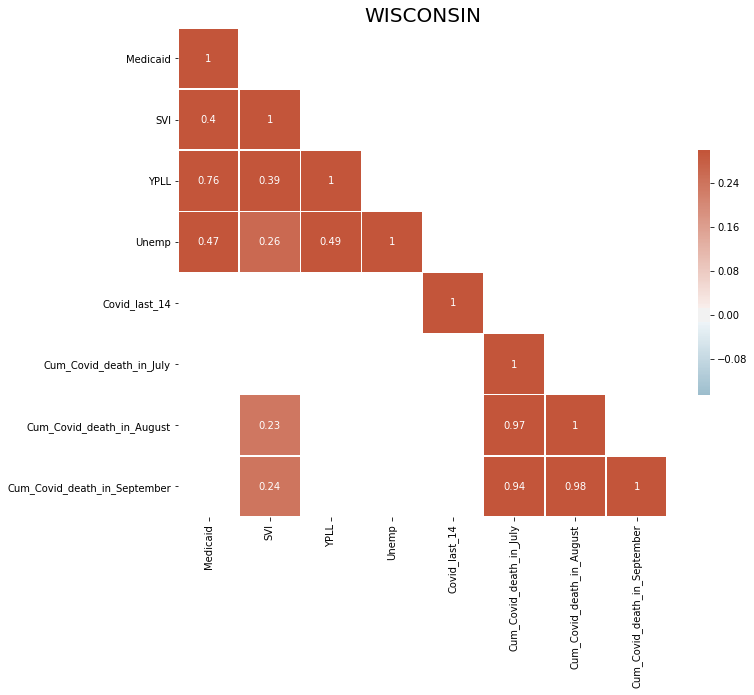

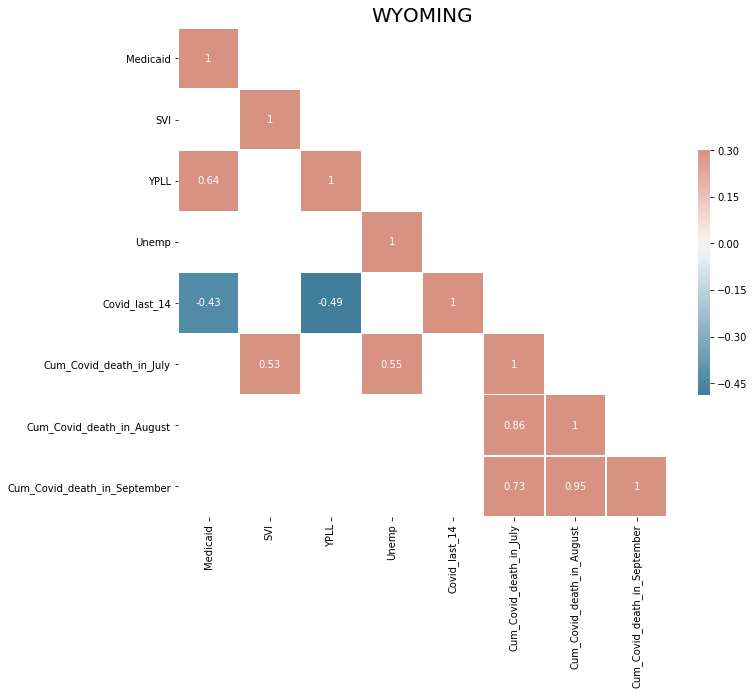

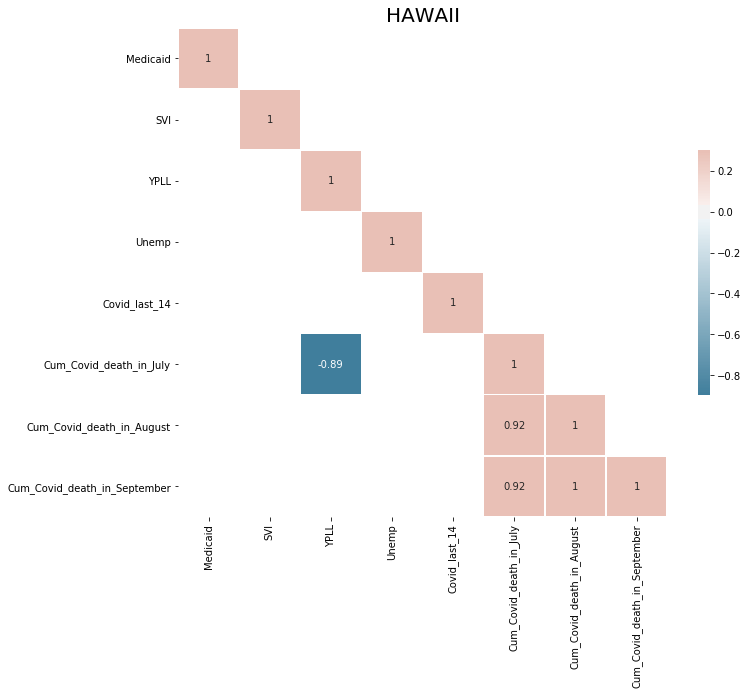

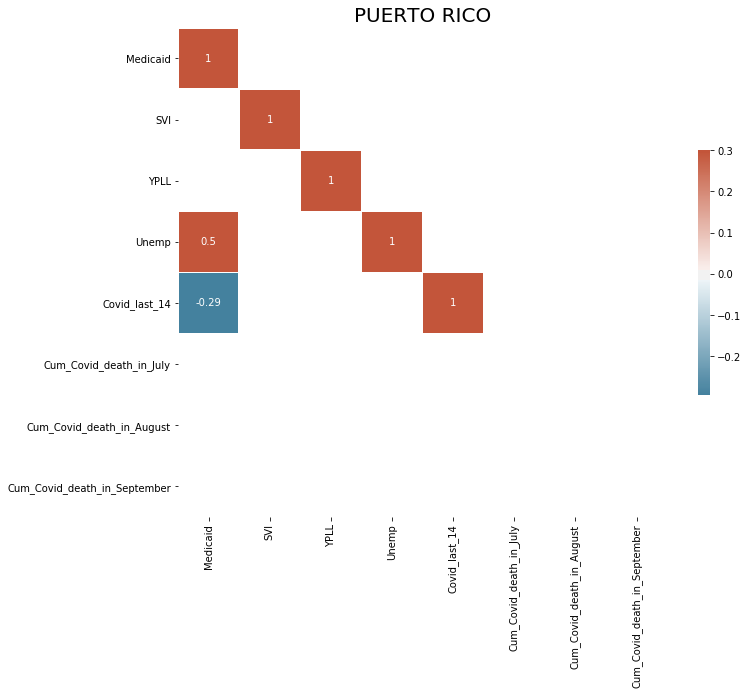

In [744]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix




for s in State:
    
    if s != "DISTRICT OF COLUMBIA":
    
        d = pd.read_csv('Output/County_level_values_'+ s +'.csv', index_col=0)
        corr = d.corr()

        # Compute the correlation matrix
        corr = d.corr(method ='spearman')
        p_values = corr_sig(d)
        mask = np.invert(np.tril(p_values < 0.05))
        
        # print (p_values)
        # Generate a mask for the upper triangle
        #mask = np.triu(np.ones_like(corr, dtype=bool))

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        plt.title(s, fontsize =20)
        #plt.xticks(rotation = 90)
        #plt.yticks(rotation = 180)
        # Draw the heatmap with the mask and correct aspect ratio
        
        ax = sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)

        plt.savefig('Output/Correlation_plot_' + s +'.png')